In [3]:
import random
import numpy as np
import sys
import gym
import torch
import pylab
from collections import deque
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms
import matplotlib.pyplot as plt
import pickle

In [2]:
# SumTree
# a binary tree data structure where the parent’s value is the sum of its children

class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

In [3]:
class Memory:  # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    #a = 0.6
    #beta = 0.4    

    def __init__(self, capacity, a, beta, beta_increment_per_sampling):
        self.tree = SumTree(capacity)
        self.capacity = capacity
        self.a = a
        self.beta = beta
        self.beta_increment_per_sampling = beta_increment_per_sampling

    def _get_priority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        p = self._get_priority(error)
        self.tree.add(p, sample)

    def sample(self, n):
        batch = []
        idxs = []
        segment = self.tree.total() / n
        priorities = []
        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            priorities.append(p)
            batch.append(data)
            idxs.append(idx)

        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(sampling_probabilities, -self.beta)
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        return batch, idxs, is_weight

    def update(self, idx, error):
        p = self._get_priority(error)
        self.tree.update(idx, p)


In [4]:
EPISODES = 500
NUM_SIM = 30

# approximate Q function using Neural Network
# state is input and Q Value of each action is output of network
class DQN(nn.Module):
    def __init__(self, num_in, num_out):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(num_in, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, num_out)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


# DQN Agent for the Cartpole
# it uses Neural Network to approximate q function
# and prioritized experience replay memory & target q network
class DQNAgent():
    def __init__(self, state_size, action_size, a, beta, beta_increment_per_sampling):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 1.0
        self.learning_rate = 0.001
        self.memory_size = 10000
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.explore_step = 10000
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / self.explore_step
        self.batch_size = 64
        self.train_start = 0

        # create prioritized replay memory using SumTree
        self.memory = Memory(self.memory_size, a, beta, beta_increment_per_sampling)

        # create main model and target model
        self.model = DQN(state_size, action_size)
        self.model.apply(self.weights_init)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(),
                                    lr=self.learning_rate)

        # initialize target model
        self.update_target_model()

        if self.load_model:
            self.model = torch.load('save_model/cartpole_dqn')

    # weight xavier initialize
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            torch.nn.init.xavier_uniform(m.weight)

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def update_epsilon(self):
        self.epsilon *= 0.95
        self.epsilon = max(self.epsilon_min, self.epsilon)
        return self.epsilon    
        
    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state = torch.from_numpy(state)
            state = Variable(state).float().cpu()
            q_value = self.model(state)
            _, action = torch.max(q_value, 1)
            return int(action)

    # save sample (error,<s,a,r,s'>) to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        target = self.model(Variable(torch.FloatTensor(state))).data
        old_val = target[0][action]
        target_val = self.target_model(Variable(torch.FloatTensor(next_state))).data
        if done:
            target[0][action] = reward
        else:
            target[0][action] = reward + self.discount_factor * torch.max(target_val)

        error = abs(old_val - target[0][action])

        self.memory.add(error, (state, action, reward, next_state, done))

    # pick samples from prioritized replay memory (with batch_size)
    def train_model(self):
        #if self.epsilon > self.epsilon_min:
        #    self.epsilon -= self.epsilon_decay

        mini_batch, idxs, is_weights = self.memory.sample(self.batch_size)
        mini_batch = np.array(mini_batch).transpose()

        states = np.vstack(mini_batch[0])
        actions = list(mini_batch[1])
        rewards = list(mini_batch[2])
        next_states = np.vstack(mini_batch[3])
        dones = mini_batch[4]

        # bool to binary
        dones = dones.astype(int)

        # Q function of current state
        states = torch.Tensor(states)
        states = Variable(states).float()
        pred = self.model(states)

        # one-hot encoding
        a = torch.LongTensor(actions).view(-1, 1)

        one_hot_action = torch.FloatTensor(self.batch_size, self.action_size).zero_()
        one_hot_action.scatter_(1, a, 1)

        pred = torch.sum(pred.mul(Variable(one_hot_action)), dim=1)

        # Q function of next state
        next_states = torch.Tensor(next_states)
        next_states = Variable(next_states).float()
        next_pred = self.target_model(next_states).data

        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        # Q Learning: get maximum Q value at s' from target model
        target = rewards + (1 - dones) * self.discount_factor * next_pred.max(1)[0]
        target = Variable(target)

        errors = torch.abs(pred - target).data.numpy()

        # update priority
        for i in range(self.batch_size):
            idx = idxs[i]
            self.memory.update(idx, errors[i])

        self.optimizer.zero_grad()

        # MSE Loss function
        is_weights = torch.from_numpy(is_weights).type(torch.FloatTensor)
        loss = F.mse_loss(is_weights* pred, is_weights* target)
        #loss = F.mse_loss(pred, target)
        loss.backward()

        # and train
        self.optimizer.step()

def P_simulation():     

    # In case of CartPole-v1, maximum length of episode is 500
    #env = gym.make('CartPole-v0')
    env = gym.make('MountainCar-v0')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    model = DQN(state_size, action_size)

    agent = DQNAgent(state_size, action_size, 0.4, 0.4, 0.0000025)
    #agent1 = DQNAgent(state_size, action_size, 0,  1.0)
    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0

        state = env.reset()  
        state = np.reshape(state, [1, state_size])

        eps = agent.update_epsilon()
        while not done:
            if agent.render:
                env.render()

            # get action for the current state and go one step in environment
            action = agent.get_action(state)

            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # if an action make the episode end, then gives penalty of -100
            #reward = reward if not done or score == 499 else -10
            reward = reward 
            # save the sample <s, a, r, s'> to the replay memory
            agent.append_sample(state, action, reward, next_state, done)
            # every time step do the training
            if agent.memory.tree.n_entries >= agent.train_start:
                agent.train_model()

            score += reward
            state = next_state

            if done:
                # every episode update the target model to be same with model
                agent.update_target_model()

                # every episode, plot the play time
                #score = score if score == 500 else score + 10
                scores.append(score)
                episodes.append(e)
                #pylab.plot(episodes, scores, 'b')
                #pylab.savefig("./save_graph/cartpole_dqn.png")
                print("episode:", e, "  score:", score, "  memory length:",
                      agent.memory.tree.n_entries, "  epsilon:", agent.epsilon, " beta", agent.memory.beta)

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                #if np.mean(scores[-min(10, len(scores)):]) > 490:
                    #torch.save(agent.model, "./save_model/cartpole_dqn")
                    #sys.exit()

    return episodes, scores

P_episodess = []
P_scoress = []

for i in range(NUM_SIM):
    episodes, scores = P_simulation()
    P_episodess += [episodes]
    P_scoress += [scores]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/qwerthjkl45/miniconda3/envs/rl2018/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


episode: 0   score: -200.0   memory length: 200   epsilon: 0.95  beta 0.4005000000000033
episode: 1   score: -200.0   memory length: 400   epsilon: 0.9025  beta 0.4010000000000066
episode: 2   score: -200.0   memory length: 600   epsilon: 0.8573749999999999  beta 0.40150000000000985
episode: 3   score: -200.0   memory length: 800   epsilon: 0.8145062499999999  beta 0.4020000000000131
episode: 4   score: -200.0   memory length: 1000   epsilon: 0.7737809374999999  beta 0.4025000000000164
episode: 5   score: -200.0   memory length: 1200   epsilon: 0.7350918906249998  beta 0.4030000000000197
episode: 6   score: -200.0   memory length: 1400   epsilon: 0.6983372960937497  beta 0.40350000000002295
episode: 7   score: -200.0   memory length: 1600   epsilon: 0.6634204312890623  beta 0.4040000000000262
episode: 8   score: -200.0   memory length: 1800   epsilon: 0.6302494097246091  beta 0.4045000000000295
episode: 9   score: -200.0   memory length: 2000   epsilon: 0.5987369392383786  beta 0.40500

episode: 81   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4410000000002686
episode: 82   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4415000000002719
episode: 83   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4420000000002752
episode: 84   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44250000000027845
episode: 85   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4430000000002817
episode: 86   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.443500000000285
episode: 87   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4440000000002883
episode: 88   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44450000000029155
episode: 89   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4450000000002948
episode: 90   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4455000000002981
episode: 91   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4460

episode: 169   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4850000000005569
episode: 170   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48550000000056015
episode: 171   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4860000000005634
episode: 172   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4865000000005667
episode: 173   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48700000000057
episode: 174   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48750000000057325
episode: 175   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48800000000057653
episode: 176   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4885000000005798
episode: 177   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4890000000005831
episode: 178   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48950000000058635
episode: 179   score: -200.0   memory length: 10000   epsilon: 0.05 

episode: 258   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5292325000008467
episode: 259   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5297325000008499
episode: 260   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5302325000008532
episode: 261   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5307325000008565
episode: 262   score: -194.0   memory length: 10000   epsilon: 0.05  beta 0.5312175000008597
episode: 263   score: -142.0   memory length: 10000   epsilon: 0.05  beta 0.531572500000862
episode: 264   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5320725000008653
episode: 265   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5325725000008685
episode: 266   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5330725000008718
episode: 267   score: -193.0   memory length: 10000   epsilon: 0.05  beta 0.533555000000875
episode: 268   score: -134.0   memory length: 10000   epsilon: 0.05  bet

episode: 347   score: -152.0   memory length: 10000   epsilon: 0.05  beta 0.5646575000010787
episode: 348   score: -158.0   memory length: 10000   epsilon: 0.05  beta 0.5650525000010813
episode: 349   score: -88.0   memory length: 10000   epsilon: 0.05  beta 0.5652725000010828
episode: 350   score: -153.0   memory length: 10000   epsilon: 0.05  beta 0.5656550000010853
episode: 351   score: -91.0   memory length: 10000   epsilon: 0.05  beta 0.5658825000010868
episode: 352   score: -160.0   memory length: 10000   epsilon: 0.05  beta 0.5662825000010894
episode: 353   score: -157.0   memory length: 10000   epsilon: 0.05  beta 0.5666750000010919
episode: 354   score: -147.0   memory length: 10000   epsilon: 0.05  beta 0.5670425000010944
episode: 355   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5675425000010976
episode: 356   score: -147.0   memory length: 10000   epsilon: 0.05  beta 0.5679100000011
episode: 357   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0

episode: 436   score: -149.0   memory length: 10000   epsilon: 0.05  beta 0.6016175000013209
episode: 437   score: -166.0   memory length: 10000   epsilon: 0.05  beta 0.6020325000013236
episode: 438   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.602395000001326
episode: 439   score: -185.0   memory length: 10000   epsilon: 0.05  beta 0.602857500001329
episode: 440   score: -148.0   memory length: 10000   epsilon: 0.05  beta 0.6032275000013314
episode: 441   score: -176.0   memory length: 10000   epsilon: 0.05  beta 0.6036675000013343
episode: 442   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.6040250000013366
episode: 443   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.6044100000013392
episode: 444   score: -139.0   memory length: 10000   epsilon: 0.05  beta 0.6047575000013414
episode: 445   score: -138.0   memory length: 10000   epsilon: 0.05  beta 0.6051025000013437
episode: 446   score: -149.0   memory length: 10000   epsilon: 0.05  bet

episode: 21   score: -200.0   memory length: 4400   epsilon: 0.3235335449737089  beta 0.4110000000000721
episode: 22   score: -200.0   memory length: 4600   epsilon: 0.30735686772502346  beta 0.41150000000007536
episode: 23   score: -200.0   memory length: 4800   epsilon: 0.2919890243387723  beta 0.41200000000007864
episode: 24   score: -200.0   memory length: 5000   epsilon: 0.27738957312183365  beta 0.4125000000000819
episode: 25   score: -200.0   memory length: 5200   epsilon: 0.263520094465742  beta 0.4130000000000852
episode: 26   score: -200.0   memory length: 5400   epsilon: 0.25034408974245487  beta 0.41350000000008846
episode: 27   score: -200.0   memory length: 5600   epsilon: 0.2378268852553321  beta 0.41400000000009174
episode: 28   score: -200.0   memory length: 5800   epsilon: 0.2259355409925655  beta 0.414500000000095
episode: 29   score: -200.0   memory length: 6000   epsilon: 0.2146387639429372  beta 0.4150000000000983
episode: 30   score: -200.0   memory length: 6200 

episode: 105   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4529150000003467
episode: 106   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45341500000034995
episode: 107   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45391500000035323
episode: 108   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4544150000003565
episode: 109   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4549150000003598
episode: 110   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45541500000036306
episode: 111   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45591500000036633
episode: 112   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4564150000003696
episode: 113   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4569150000003729
episode: 114   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45741500000037616
episode: 115   score: -200.0   memory length: 10000   epsilon: 0.

episode: 193   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4968225000006343
episode: 194   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4973225000006376
episode: 195   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4978225000006409
episode: 196   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49832250000064415
episode: 197   score: -196.0   memory length: 10000   epsilon: 0.05  beta 0.49881250000064736
episode: 198   score: -133.0   memory length: 10000   epsilon: 0.05  beta 0.49914500000064954
episode: 199   score: -172.0   memory length: 10000   epsilon: 0.05  beta 0.49957500000065236
episode: 200   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5000750000006556
episode: 201   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5005750000006589
episode: 202   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5010750000006622
episode: 203   score: -166.0   memory length: 10000   epsilon: 0.0

episode: 282   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.533720000000876
episode: 283   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.5341100000008786
episode: 284   score: -158.0   memory length: 10000   epsilon: 0.05  beta 0.5345050000008812
episode: 285   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.5348900000008837
episode: 286   score: -165.0   memory length: 10000   epsilon: 0.05  beta 0.5353025000008864
episode: 287   score: -153.0   memory length: 10000   epsilon: 0.05  beta 0.5356850000008889
episode: 288   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.5360625000008914
episode: 289   score: -152.0   memory length: 10000   epsilon: 0.05  beta 0.5364425000008939
episode: 290   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.5368325000008964
episode: 291   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.5372100000008989
episode: 292   score: -161.0   memory length: 10000   epsilon: 0.05  be

episode: 371   score: -116.0   memory length: 10000   epsilon: 0.05  beta 0.5652850000010828
episode: 372   score: -141.0   memory length: 10000   epsilon: 0.05  beta 0.5656375000010851
episode: 373   score: -171.0   memory length: 10000   epsilon: 0.05  beta 0.566065000001088
episode: 374   score: -167.0   memory length: 10000   epsilon: 0.05  beta 0.5664825000010907
episode: 375   score: -123.0   memory length: 10000   epsilon: 0.05  beta 0.5667900000010927
episode: 376   score: -118.0   memory length: 10000   epsilon: 0.05  beta 0.5670850000010946
episode: 377   score: -127.0   memory length: 10000   epsilon: 0.05  beta 0.5674025000010967
episode: 378   score: -124.0   memory length: 10000   epsilon: 0.05  beta 0.5677125000010987
episode: 379   score: -119.0   memory length: 10000   epsilon: 0.05  beta 0.5680100000011007
episode: 380   score: -118.0   memory length: 10000   epsilon: 0.05  beta 0.5683050000011026
episode: 381   score: -130.0   memory length: 10000   epsilon: 0.05  be

episode: 460   score: -169.0   memory length: 10000   epsilon: 0.05  beta 0.5997050000013083
episode: 461   score: -176.0   memory length: 10000   epsilon: 0.05  beta 0.6001450000013112
episode: 462   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6006450000013145
episode: 463   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6011450000013178
episode: 464   score: -175.0   memory length: 10000   epsilon: 0.05  beta 0.6015825000013206
episode: 465   score: -163.0   memory length: 10000   epsilon: 0.05  beta 0.6019900000013233
episode: 466   score: -169.0   memory length: 10000   epsilon: 0.05  beta 0.6024125000013261
episode: 467   score: -167.0   memory length: 10000   epsilon: 0.05  beta 0.6028300000013288
episode: 468   score: -164.0   memory length: 10000   epsilon: 0.05  beta 0.6032400000013315
episode: 469   score: -184.0   memory length: 10000   epsilon: 0.05  beta 0.6037000000013345
episode: 470   score: -170.0   memory length: 10000   epsilon: 0.05  b

episode: 42   score: -200.0   memory length: 8600   epsilon: 0.11018311023500525  beta 0.4215000000001409
episode: 43   score: -200.0   memory length: 8800   epsilon: 0.10467395472325498  beta 0.42200000000014415
episode: 44   score: -200.0   memory length: 9000   epsilon: 0.09944025698709223  beta 0.4225000000001474
episode: 45   score: -200.0   memory length: 9200   epsilon: 0.09446824413773762  beta 0.4230000000001507
episode: 46   score: -200.0   memory length: 9400   epsilon: 0.08974483193085074  beta 0.423500000000154
episode: 47   score: -200.0   memory length: 9600   epsilon: 0.0852575903343082  beta 0.42400000000015725
episode: 48   score: -200.0   memory length: 9800   epsilon: 0.08099471081759278  beta 0.4245000000001605
episode: 49   score: -200.0   memory length: 10000   epsilon: 0.07694497527671314  beta 0.4250000000001638
episode: 50   score: -200.0   memory length: 10000   epsilon: 0.07309772651287748  beta 0.4255000000001671
episode: 51   score: -200.0   memory length:

episode: 128   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4645000000004226
episode: 129   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46500000000042585
episode: 130   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4655000000004291
episode: 131   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4660000000004324
episode: 132   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4665000000004357
episode: 133   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46700000000043895
episode: 134   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46750000000044223
episode: 135   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4680000000004455
episode: 136   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4685000000004488
episode: 137   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46900000000045206
episode: 138   score: -200.0   memory length: 10000   epsilon: 0.0

episode: 216   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5041725000006825
episode: 217   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5046725000006858
episode: 218   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.505172500000689
episode: 219   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5056725000006923
episode: 220   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5061725000006956
episode: 221   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5066725000006989
episode: 222   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5071725000007021
episode: 223   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5076725000007054
episode: 224   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5081725000007087
episode: 225   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.508672500000712
episode: 226   score: -200.0   memory length: 10000   epsilon: 0.05  bet

episode: 305   score: -86.0   memory length: 10000   epsilon: 0.05  beta 0.5403975000009198
episode: 306   score: -107.0   memory length: 10000   epsilon: 0.05  beta 0.5406650000009215
episode: 307   score: -107.0   memory length: 10000   epsilon: 0.05  beta 0.5409325000009233
episode: 308   score: -112.0   memory length: 10000   epsilon: 0.05  beta 0.5412125000009251
episode: 309   score: -109.0   memory length: 10000   epsilon: 0.05  beta 0.5414850000009269
episode: 310   score: -113.0   memory length: 10000   epsilon: 0.05  beta 0.5417675000009288
episode: 311   score: -103.0   memory length: 10000   epsilon: 0.05  beta 0.5420250000009305
episode: 312   score: -108.0   memory length: 10000   epsilon: 0.05  beta 0.5422950000009322
episode: 313   score: -110.0   memory length: 10000   epsilon: 0.05  beta 0.542570000000934
episode: 314   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5430700000009373
episode: 315   score: -133.0   memory length: 10000   epsilon: 0.05  bet

episode: 394   score: -193.0   memory length: 10000   epsilon: 0.05  beta 0.5707100000011184
episode: 395   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.5710975000011209
episode: 396   score: -97.0   memory length: 10000   epsilon: 0.05  beta 0.5713400000011225
episode: 397   score: -194.0   memory length: 10000   epsilon: 0.05  beta 0.5718250000011257
episode: 398   score: -142.0   memory length: 10000   epsilon: 0.05  beta 0.572180000001128
episode: 399   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.5725425000011304
episode: 400   score: -144.0   memory length: 10000   epsilon: 0.05  beta 0.5729025000011327
episode: 401   score: -141.0   memory length: 10000   epsilon: 0.05  beta 0.573255000001135
episode: 402   score: -163.0   memory length: 10000   epsilon: 0.05  beta 0.5736625000011377
episode: 403   score: -153.0   memory length: 10000   epsilon: 0.05  beta 0.5740450000011402
episode: 404   score: -144.0   memory length: 10000   epsilon: 0.05  beta

episode: 483   score: -93.0   memory length: 10000   epsilon: 0.05  beta 0.6034050000013326
episode: 484   score: -167.0   memory length: 10000   epsilon: 0.05  beta 0.6038225000013353
episode: 485   score: -182.0   memory length: 10000   epsilon: 0.05  beta 0.6042775000013383
episode: 486   score: -171.0   memory length: 10000   epsilon: 0.05  beta 0.6047050000013411
episode: 487   score: -164.0   memory length: 10000   epsilon: 0.05  beta 0.6051150000013438
episode: 488   score: -169.0   memory length: 10000   epsilon: 0.05  beta 0.6055375000013465
episode: 489   score: -101.0   memory length: 10000   epsilon: 0.05  beta 0.6057900000013482
episode: 490   score: -163.0   memory length: 10000   epsilon: 0.05  beta 0.6061975000013509
episode: 491   score: -171.0   memory length: 10000   epsilon: 0.05  beta 0.6066250000013537
episode: 492   score: -115.0   memory length: 10000   epsilon: 0.05  beta 0.6069125000013555
episode: 493   score: -171.0   memory length: 10000   epsilon: 0.05  be

episode: 63   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43200000000020966
episode: 64   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43250000000021294
episode: 65   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4330000000002162
episode: 66   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4335000000002195
episode: 67   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43400000000022276
episode: 68   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43450000000022604
episode: 69   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4350000000002293
episode: 70   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4355000000002326
episode: 71   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43600000000023587
episode: 72   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43650000000023914
episode: 73   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0

episode: 152   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4765000000005012
episode: 153   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47700000000050446
episode: 154   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47750000000050774
episode: 155   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.478000000000511
episode: 156   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4785000000005143
episode: 157   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47900000000051757
episode: 158   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47950000000052084
episode: 159   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4800000000005241
episode: 160   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4805000000005274
episode: 161   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48100000000053067
episode: 162   score: -200.0   memory length: 10000   epsilon: 0.0

episode: 240   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.518605000000777
episode: 241   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5191050000007803
episode: 242   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5196050000007836
episode: 243   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5201050000007869
episode: 244   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5206050000007901
episode: 245   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5211050000007934
episode: 246   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5216050000007967
episode: 247   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5221050000008
episode: 248   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5226050000008032
episode: 249   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5231050000008065
episode: 250   score: -200.0   memory length: 10000   epsilon: 0.05  beta 

episode: 329   score: -158.0   memory length: 10000   epsilon: 0.05  beta 0.5623125000010634
episode: 330   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5628125000010666
episode: 331   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.5632025000010692
episode: 332   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5637025000010725
episode: 333   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5642025000010757
episode: 334   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.5645800000010782
episode: 335   score: -158.0   memory length: 10000   epsilon: 0.05  beta 0.5649750000010808
episode: 336   score: -162.0   memory length: 10000   epsilon: 0.05  beta 0.5653800000010835
episode: 337   score: -181.0   memory length: 10000   epsilon: 0.05  beta 0.5658325000010864
episode: 338   score: -182.0   memory length: 10000   epsilon: 0.05  beta 0.5662875000010894
episode: 339   score: -163.0   memory length: 10000   epsilon: 0.05  b

episode: 418   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6010750000013173
episode: 419   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6015750000013206
episode: 420   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6020750000013239
episode: 421   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6025750000013271
episode: 422   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6030750000013304
episode: 423   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6035750000013337
episode: 424   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.604075000001337
episode: 425   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6045750000013402
episode: 426   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6050750000013435
episode: 427   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6055750000013468
episode: 428   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 5   score: -200.0   memory length: 1200   epsilon: 0.7350918906249998  beta 0.4030000000000197
episode: 6   score: -200.0   memory length: 1400   epsilon: 0.6983372960937497  beta 0.40350000000002295
episode: 7   score: -200.0   memory length: 1600   epsilon: 0.6634204312890623  beta 0.4040000000000262
episode: 8   score: -200.0   memory length: 1800   epsilon: 0.6302494097246091  beta 0.4045000000000295
episode: 9   score: -200.0   memory length: 2000   epsilon: 0.5987369392383786  beta 0.4050000000000328
episode: 10   score: -200.0   memory length: 2200   epsilon: 0.5688000922764596  beta 0.40550000000003605
episode: 11   score: -200.0   memory length: 2400   epsilon: 0.5403600876626365  beta 0.40600000000003933
episode: 12   score: -200.0   memory length: 2600   epsilon: 0.5133420832795047  beta 0.4065000000000426
episode: 13   score: -200.0   memory length: 2800   epsilon: 0.48767497911552943  beta 0.4070000000000459
episode: 14   score: -200.0   memory length: 3000   epsi

episode: 86   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.443500000000285
episode: 87   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4440000000002883
episode: 88   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44450000000029155
episode: 89   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4450000000002948
episode: 90   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4455000000002981
episode: 91   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4460000000003014
episode: 92   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44650000000030465
episode: 93   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44700000000030793
episode: 94   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4475000000003112
episode: 95   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4480000000003145
episode: 96   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.448

episode: 174   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48750000000057325
episode: 175   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48800000000057653
episode: 176   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4885000000005798
episode: 177   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4890000000005831
episode: 178   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48950000000058635
episode: 179   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49000000000058963
episode: 180   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4905000000005929
episode: 181   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4910000000005962
episode: 182   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49150000000059946
episode: 183   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49200000000060273
episode: 184   score: -200.0   memory length: 10000   epsilon: 0

episode: 263   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5320000000008648
episode: 264   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5325000000008681
episode: 265   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5330000000008713
episode: 266   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5335000000008746
episode: 267   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5340000000008779
episode: 268   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5345000000008812
episode: 269   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5350000000008844
episode: 270   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5355000000008877
episode: 271   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.536000000000891
episode: 272   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5365000000008943
episode: 273   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 352   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5765000000011563
episode: 353   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5770000000011596
episode: 354   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5775000000011629
episode: 355   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5780000000011661
episode: 356   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5785000000011694
episode: 357   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5790000000011727
episode: 358   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.579500000001176
episode: 359   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5800000000011792
episode: 360   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5805000000011825
episode: 361   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5810000000011858
episode: 362   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 441   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6208200000014467
episode: 442   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6213200000014499
episode: 443   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6218200000014532
episode: 444   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6223200000014565
episode: 445   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6228200000014598
episode: 446   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.623320000001463
episode: 447   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6238200000014663
episode: 448   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6243200000014696
episode: 449   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6248200000014729
episode: 450   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6253200000014761
episode: 451   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 26   score: -200.0   memory length: 5400   epsilon: 0.25034408974245487  beta 0.41350000000008846
episode: 27   score: -200.0   memory length: 5600   epsilon: 0.2378268852553321  beta 0.41400000000009174
episode: 28   score: -200.0   memory length: 5800   epsilon: 0.2259355409925655  beta 0.414500000000095
episode: 29   score: -200.0   memory length: 6000   epsilon: 0.2146387639429372  beta 0.4150000000000983
episode: 30   score: -200.0   memory length: 6200   epsilon: 0.20390682574579033  beta 0.41550000000010157
episode: 31   score: -200.0   memory length: 6400   epsilon: 0.1937114844585008  beta 0.41600000000010484
episode: 32   score: -200.0   memory length: 6600   epsilon: 0.18402591023557577  beta 0.4165000000001081
episode: 33   score: -200.0   memory length: 6800   epsilon: 0.17482461472379698  beta 0.4170000000001114
episode: 34   score: -200.0   memory length: 7000   epsilon: 0.16608338398760714  beta 0.41750000000011467
episode: 35   score: -200.0   memory length: 7

episode: 110   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4555000000003636
episode: 111   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4560000000003669
episode: 112   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45650000000037017
episode: 113   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45700000000037344
episode: 114   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4575000000003767
episode: 115   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45800000000038
episode: 116   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45850000000038327
episode: 117   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45900000000038654
episode: 118   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4595000000003898
episode: 119   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4600000000003931
episode: 120   score: -200.0   memory length: 10000   epsilon: 0.05 

episode: 198   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4987250000006468
episode: 199   score: -191.0   memory length: 10000   epsilon: 0.05  beta 0.4992025000006499
episode: 200   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4997025000006532
episode: 201   score: -183.0   memory length: 10000   epsilon: 0.05  beta 0.5001600000006562
episode: 202   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5006600000006595
episode: 203   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5011600000006627
episode: 204   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.501660000000666
episode: 205   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5021600000006693
episode: 206   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5026600000006726
episode: 207   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5031600000006758
episode: 208   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 287   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5391850000009119
episode: 288   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5396850000009151
episode: 289   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5401850000009184
episode: 290   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5406850000009217
episode: 291   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.541185000000925
episode: 292   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5416850000009282
episode: 293   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5421850000009315
episode: 294   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5426850000009348
episode: 295   score: -184.0   memory length: 10000   epsilon: 0.05  beta 0.5431450000009378
episode: 296   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5436450000009411
episode: 297   score: -175.0   memory length: 10000   epsilon: 0.05  be

episode: 376   score: -165.0   memory length: 10000   epsilon: 0.05  beta 0.5762550000011547
episode: 377   score: -121.0   memory length: 10000   epsilon: 0.05  beta 0.5765575000011567
episode: 378   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.57705750000116
episode: 379   score: -125.0   memory length: 10000   epsilon: 0.05  beta 0.577370000001162
episode: 380   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5778700000011653
episode: 381   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5783700000011686
episode: 382   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5788700000011718
episode: 383   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5793700000011751
episode: 384   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5798700000011784
episode: 385   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5803700000011817
episode: 386   score: -200.0   memory length: 10000   epsilon: 0.05  beta

episode: 465   score: -126.0   memory length: 10000   epsilon: 0.05  beta 0.6116575000013866
episode: 466   score: -133.0   memory length: 10000   epsilon: 0.05  beta 0.6119900000013888
episode: 467   score: -121.0   memory length: 10000   epsilon: 0.05  beta 0.6122925000013908
episode: 468   score: -135.0   memory length: 10000   epsilon: 0.05  beta 0.612630000001393
episode: 469   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6131300000013963
episode: 470   score: -185.0   memory length: 10000   epsilon: 0.05  beta 0.6135925000013993
episode: 471   score: -114.0   memory length: 10000   epsilon: 0.05  beta 0.6138775000014012
episode: 472   score: -115.0   memory length: 10000   epsilon: 0.05  beta 0.6141650000014031
episode: 473   score: -175.0   memory length: 10000   epsilon: 0.05  beta 0.6146025000014059
episode: 474   score: -124.0   memory length: 10000   epsilon: 0.05  beta 0.614912500001408
episode: 475   score: -118.0   memory length: 10000   epsilon: 0.05  bet

episode: 47   score: -200.0   memory length: 9600   epsilon: 0.0852575903343082  beta 0.42400000000015725
episode: 48   score: -200.0   memory length: 9800   epsilon: 0.08099471081759278  beta 0.4245000000001605
episode: 49   score: -200.0   memory length: 10000   epsilon: 0.07694497527671314  beta 0.4250000000001638
episode: 50   score: -200.0   memory length: 10000   epsilon: 0.07309772651287748  beta 0.4255000000001671
episode: 51   score: -200.0   memory length: 10000   epsilon: 0.0694428401872336  beta 0.42600000000017035
episode: 52   score: -200.0   memory length: 10000   epsilon: 0.0659706981778719  beta 0.42650000000017363
episode: 53   score: -200.0   memory length: 10000   epsilon: 0.0626721632689783  beta 0.4270000000001769
episode: 54   score: -200.0   memory length: 10000   epsilon: 0.059538555105529384  beta 0.4275000000001802
episode: 55   score: -200.0   memory length: 10000   epsilon: 0.05656162735025291  beta 0.42800000000018346
episode: 56   score: -173.0   memory l

episode: 134   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4673750000004414
episode: 135   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4678750000004447
episode: 136   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46837500000044796
episode: 137   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46887500000045124
episode: 138   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4693750000004545
episode: 139   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4698750000004578
episode: 140   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47037500000046106
episode: 141   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47087500000046434
episode: 142   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4713750000004676
episode: 143   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4718750000004709
episode: 144   score: -200.0   memory length: 10000   epsilon: 0.0

episode: 222   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5113750000007297
episode: 223   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5118750000007329
episode: 224   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5123750000007362
episode: 225   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5128750000007395
episode: 226   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5133750000007428
episode: 227   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.513875000000746
episode: 228   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5143750000007493
episode: 229   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5148750000007526
episode: 230   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5153750000007559
episode: 231   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5158750000007591
episode: 232   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 311   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5558750000010212
episode: 312   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5563750000010245
episode: 313   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5568750000010277
episode: 314   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.557375000001031
episode: 315   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5578750000010343
episode: 316   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5583750000010376
episode: 317   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5588750000010408
episode: 318   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5593750000010441
episode: 319   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5598750000010474
episode: 320   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5603750000010507
episode: 321   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 400   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6003750000013127
episode: 401   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.600875000001316
episode: 402   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6013750000013193
episode: 403   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6018750000013225
episode: 404   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6023750000013258
episode: 405   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6028750000013291
episode: 406   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6033750000013324
episode: 407   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6038750000013356
episode: 408   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6043750000013389
episode: 409   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6048750000013422
episode: 410   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 489   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6448750000016042
episode: 490   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6453750000016075
episode: 491   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6458750000016108
episode: 492   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6463750000016141
episode: 493   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6468750000016174
episode: 494   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6473750000016206
episode: 495   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6478750000016239
episode: 496   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6483750000016272
episode: 497   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6488750000016305
episode: 498   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6493750000016337
episode: 499   score: -200.0   memory length: 10000   epsilon: 0.05  b

episode: 69   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4350000000002293
episode: 70   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4355000000002326
episode: 71   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43600000000023587
episode: 72   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43650000000023914
episode: 73   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4370000000002424
episode: 74   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4375000000002457
episode: 75   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43800000000024897
episode: 76   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43850000000025224
episode: 77   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4390000000002555
episode: 78   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4395000000002588
episode: 79   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4

episode: 158   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47947250000052066
episode: 159   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47997250000052394
episode: 160   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4804725000005272
episode: 161   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4809725000005305
episode: 162   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48147250000053377
episode: 163   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48197250000053704
episode: 164   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4824725000005403
episode: 165   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4829725000005436
episode: 166   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48347250000054687
episode: 167   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48397250000055014
episode: 168   score: -200.0   memory length: 10000   epsilon: 0

episode: 246   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5233425000008081
episode: 247   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5238425000008113
episode: 248   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5243425000008146
episode: 249   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5248425000008179
episode: 250   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5253425000008212
episode: 251   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5258425000008244
episode: 252   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5263425000008277
episode: 253   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.526842500000831
episode: 254   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5273425000008343
episode: 255   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5278425000008375
episode: 256   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 335   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5647625000010794
episode: 336   score: -184.0   memory length: 10000   epsilon: 0.05  beta 0.5652225000010824
episode: 337   score: -197.0   memory length: 10000   epsilon: 0.05  beta 0.5657150000010857
episode: 338   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5662150000010889
episode: 339   score: -194.0   memory length: 10000   epsilon: 0.05  beta 0.5667000000010921
episode: 340   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5672000000010954
episode: 341   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5677000000010987
episode: 342   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5682000000011019
episode: 343   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5687000000011052
episode: 344   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5692000000011085
episode: 345   score: -126.0   memory length: 10000   epsilon: 0.05  b

episode: 424   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6083150000013647
episode: 425   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.608815000001368
episode: 426   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6093150000013713
episode: 427   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6098150000013746
episode: 428   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6103150000013778
episode: 429   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6108150000013811
episode: 430   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6113150000013844
episode: 431   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6118150000013877
episode: 432   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6123150000013909
episode: 433   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6128150000013942
episode: 434   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 11   score: -200.0   memory length: 2400   epsilon: 0.5403600876626365  beta 0.40600000000003933
episode: 12   score: -200.0   memory length: 2600   epsilon: 0.5133420832795047  beta 0.4065000000000426
episode: 13   score: -200.0   memory length: 2800   epsilon: 0.48767497911552943  beta 0.4070000000000459
episode: 14   score: -200.0   memory length: 3000   epsilon: 0.46329123015975293  beta 0.40750000000004916
episode: 15   score: -200.0   memory length: 3200   epsilon: 0.44012666865176525  beta 0.40800000000005243
episode: 16   score: -200.0   memory length: 3400   epsilon: 0.41812033521917696  beta 0.4085000000000557
episode: 17   score: -200.0   memory length: 3600   epsilon: 0.3972143184582181  beta 0.409000000000059
episode: 18   score: -200.0   memory length: 3800   epsilon: 0.37735360253530714  beta 0.40950000000006226
episode: 19   score: -200.0   memory length: 4000   epsilon: 0.35848592240854177  beta 0.41000000000006553
episode: 20   score: -200.0   memory length: 

episode: 93   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44700000000030793
episode: 94   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4475000000003112
episode: 95   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4480000000003145
episode: 96   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44850000000031776
episode: 97   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44900000000032103
episode: 98   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4495000000003243
episode: 99   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4500000000003276
episode: 100   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45050000000033086
episode: 101   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45100000000033413
episode: 102   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4515000000003374
episode: 103   score: -200.0   memory length: 10000   epsilon: 0.05  bet

episode: 181   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49069250000059417
episode: 182   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49119250000059744
episode: 183   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4916925000006007
episode: 184   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.492192500000604
episode: 185   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49269250000060727
episode: 186   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49319250000061055
episode: 187   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4936925000006138
episode: 188   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4941925000006171
episode: 189   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49469250000062037
episode: 190   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49519250000062365
episode: 191   score: -200.0   memory length: 10000   epsilon: 0.

episode: 270   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5351925000008857
episode: 271   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.535692500000889
episode: 272   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5361925000008922
episode: 273   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5366925000008955
episode: 274   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5371925000008988
episode: 275   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5376925000009021
episode: 276   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5381925000009053
episode: 277   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5386925000009086
episode: 278   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5391925000009119
episode: 279   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5396925000009152
episode: 280   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 359   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5796925000011772
episode: 360   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5801925000011805
episode: 361   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5806925000011838
episode: 362   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.581192500001187
episode: 363   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5816925000011903
episode: 364   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5821925000011936
episode: 365   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5826925000011969
episode: 366   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5831925000012002
episode: 367   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5836925000012034
episode: 368   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5841925000012067
episode: 369   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 448   score: -97.0   memory length: 10000   epsilon: 0.05  beta 0.6231475000014619
episode: 449   score: -147.0   memory length: 10000   epsilon: 0.05  beta 0.6235150000014643
episode: 450   score: -153.0   memory length: 10000   epsilon: 0.05  beta 0.6238975000014668
episode: 451   score: -144.0   memory length: 10000   epsilon: 0.05  beta 0.6242575000014692
episode: 452   score: -161.0   memory length: 10000   epsilon: 0.05  beta 0.6246600000014718
episode: 453   score: -109.0   memory length: 10000   epsilon: 0.05  beta 0.6249325000014736
episode: 454   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.6252900000014759
episode: 455   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.6256525000014783
episode: 456   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.6260100000014807
episode: 457   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.626372500001483
episode: 458   score: -147.0   memory length: 10000   epsilon: 0.05  bet

episode: 32   score: -200.0   memory length: 6600   epsilon: 0.18402591023557577  beta 0.4165000000001081
episode: 33   score: -200.0   memory length: 6800   epsilon: 0.17482461472379698  beta 0.4170000000001114
episode: 34   score: -200.0   memory length: 7000   epsilon: 0.16608338398760714  beta 0.41750000000011467
episode: 35   score: -200.0   memory length: 7200   epsilon: 0.15777921478822676  beta 0.41800000000011794
episode: 36   score: -200.0   memory length: 7400   epsilon: 0.14989025404881542  beta 0.4185000000001212
episode: 37   score: -200.0   memory length: 7600   epsilon: 0.14239574134637464  beta 0.4190000000001245
episode: 38   score: -200.0   memory length: 7800   epsilon: 0.1352759542790559  beta 0.41950000000012777
episode: 39   score: -200.0   memory length: 8000   epsilon: 0.1285121565651031  beta 0.42000000000013105
episode: 40   score: -200.0   memory length: 8200   epsilon: 0.12208654873684793  beta 0.4205000000001343
episode: 41   score: -200.0   memory length:

episode: 117   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45803750000038024
episode: 118   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4585375000003835
episode: 119   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4590375000003868
episode: 120   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45953750000039006
episode: 121   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46003750000039334
episode: 122   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4605375000003966
episode: 123   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4610375000003999
episode: 124   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46153750000040317
episode: 125   score: -133.0   memory length: 10000   epsilon: 0.05  beta 0.46187000000040535
episode: 126   score: -180.0   memory length: 10000   epsilon: 0.05  beta 0.4623200000004083
episode: 127   score: -200.0   memory length: 10000   epsilon: 0.

episode: 205   score: -167.0   memory length: 10000   epsilon: 0.05  beta 0.4936625000006136
episode: 206   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.49404750000061615
episode: 207   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4945475000006194
episode: 208   score: -163.0   memory length: 10000   epsilon: 0.05  beta 0.4949550000006221
episode: 209   score: -170.0   memory length: 10000   epsilon: 0.05  beta 0.4953800000006249
episode: 210   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.4957675000006274
episode: 211   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4962675000006307
episode: 212   score: -182.0   memory length: 10000   epsilon: 0.05  beta 0.49672250000063367
episode: 213   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.49710000000063614
episode: 214   score: -150.0   memory length: 10000   epsilon: 0.05  beta 0.4974750000006386
episode: 215   score: -157.0   memory length: 10000   epsilon: 0.05

episode: 294   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.5298475000008507
episode: 295   score: -149.0   memory length: 10000   epsilon: 0.05  beta 0.5302200000008531
episode: 296   score: -148.0   memory length: 10000   epsilon: 0.05  beta 0.5305900000008555
episode: 297   score: -147.0   memory length: 10000   epsilon: 0.05  beta 0.530957500000858
episode: 298   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.5313350000008604
episode: 299   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.531720000000863
episode: 300   score: -158.0   memory length: 10000   epsilon: 0.05  beta 0.5321150000008655
episode: 301   score: -149.0   memory length: 10000   epsilon: 0.05  beta 0.532487500000868
episode: 302   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.5328750000008705
episode: 303   score: -152.0   memory length: 10000   epsilon: 0.05  beta 0.533255000000873
episode: 304   score: -120.0   memory length: 10000   epsilon: 0.05  beta 

episode: 383   score: -178.0   memory length: 10000   epsilon: 0.05  beta 0.5641300000010753
episode: 384   score: -94.0   memory length: 10000   epsilon: 0.05  beta 0.5643650000010768
episode: 385   score: -159.0   memory length: 10000   epsilon: 0.05  beta 0.5647625000010794
episode: 386   score: -171.0   memory length: 10000   epsilon: 0.05  beta 0.5651900000010822
episode: 387   score: -189.0   memory length: 10000   epsilon: 0.05  beta 0.5656625000010853
episode: 388   score: -166.0   memory length: 10000   epsilon: 0.05  beta 0.566077500001088
episode: 389   score: -167.0   memory length: 10000   epsilon: 0.05  beta 0.5664950000010908
episode: 390   score: -92.0   memory length: 10000   epsilon: 0.05  beta 0.5667250000010923
episode: 391   score: -161.0   memory length: 10000   epsilon: 0.05  beta 0.5671275000010949
episode: 392   score: -164.0   memory length: 10000   epsilon: 0.05  beta 0.5675375000010976
episode: 393   score: -163.0   memory length: 10000   epsilon: 0.05  beta

episode: 472   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.5968200000012894
episode: 473   score: -142.0   memory length: 10000   epsilon: 0.05  beta 0.5971750000012918
episode: 474   score: -146.0   memory length: 10000   epsilon: 0.05  beta 0.5975400000012941
episode: 475   score: -183.0   memory length: 10000   epsilon: 0.05  beta 0.5979975000012971
episode: 476   score: -138.0   memory length: 10000   epsilon: 0.05  beta 0.5983425000012994
episode: 477   score: -187.0   memory length: 10000   epsilon: 0.05  beta 0.5988100000013025
episode: 478   score: -142.0   memory length: 10000   epsilon: 0.05  beta 0.5991650000013048
episode: 479   score: -147.0   memory length: 10000   epsilon: 0.05  beta 0.5995325000013072
episode: 480   score: -146.0   memory length: 10000   epsilon: 0.05  beta 0.5998975000013096
episode: 481   score: -149.0   memory length: 10000   epsilon: 0.05  beta 0.600270000001312
episode: 482   score: -151.0   memory length: 10000   epsilon: 0.05  be

episode: 53   score: -200.0   memory length: 10000   epsilon: 0.0626721632689783  beta 0.4270000000001769
episode: 54   score: -200.0   memory length: 10000   epsilon: 0.059538555105529384  beta 0.4275000000001802
episode: 55   score: -200.0   memory length: 10000   epsilon: 0.05656162735025291  beta 0.42800000000018346
episode: 56   score: -200.0   memory length: 10000   epsilon: 0.053733545982740265  beta 0.42850000000018673
episode: 57   score: -200.0   memory length: 10000   epsilon: 0.05104686868360325  beta 0.42900000000019
episode: 58   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4295000000001933
episode: 59   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43000000000019656
episode: 60   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43050000000019983
episode: 61   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4310000000002031
episode: 62   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4315000000002064
ep

episode: 141   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47100000000046516
episode: 142   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47150000000046843
episode: 143   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4720000000004717
episode: 144   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.472500000000475
episode: 145   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47300000000047826
episode: 146   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47350000000048154
episode: 147   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4740000000004848
episode: 148   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4745000000004881
episode: 149   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47500000000049136
episode: 150   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47550000000049464
episode: 151   score: -200.0   memory length: 10000   epsilon: 0.

episode: 229   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5150000000007534
episode: 230   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5155000000007567
episode: 231   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.51600000000076
episode: 232   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5165000000007632
episode: 233   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5170000000007665
episode: 234   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5175000000007698
episode: 235   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5180000000007731
episode: 236   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5185000000007763
episode: 237   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5190000000007796
episode: 238   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5195000000007829
episode: 239   score: -200.0   memory length: 10000   epsilon: 0.05  bet

episode: 318   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5566375000010262
episode: 319   score: -173.0   memory length: 10000   epsilon: 0.05  beta 0.557070000001029
episode: 320   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.5574600000010316
episode: 321   score: -140.0   memory length: 10000   epsilon: 0.05  beta 0.5578100000010339
episode: 322   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5583100000010371
episode: 323   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5588100000010404
episode: 324   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5593100000010437
episode: 325   score: -127.0   memory length: 10000   epsilon: 0.05  beta 0.5596275000010458
episode: 326   score: -135.0   memory length: 10000   epsilon: 0.05  beta 0.559965000001048
episode: 327   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5604650000010513
episode: 328   score: -121.0   memory length: 10000   epsilon: 0.05  bet

episode: 407   score: -159.0   memory length: 10000   epsilon: 0.05  beta 0.5947375000012758
episode: 408   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5952375000012791
episode: 409   score: -163.0   memory length: 10000   epsilon: 0.05  beta 0.5956450000012817
episode: 410   score: -157.0   memory length: 10000   epsilon: 0.05  beta 0.5960375000012843
episode: 411   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5965375000012876
episode: 412   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5970375000012909
episode: 413   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5975375000012941
episode: 414   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5980375000012974
episode: 415   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5985375000013007
episode: 416   score: -138.0   memory length: 10000   epsilon: 0.05  beta 0.5988825000013029
episode: 417   score: -128.0   memory length: 10000   epsilon: 0.05  b

episode: 496   score: -166.0   memory length: 10000   epsilon: 0.05  beta 0.6304750000015099
episode: 497   score: -174.0   memory length: 10000   epsilon: 0.05  beta 0.6309100000015128
episode: 498   score: -174.0   memory length: 10000   epsilon: 0.05  beta 0.6313450000015156
episode: 499   score: -142.0   memory length: 10000   epsilon: 0.05  beta 0.6317000000015179
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode: 0   score: -200.0   memory length: 200   epsilon: 0.95  beta 0.4005000000000033
episode: 1   score: -200.0   memory length: 400   epsilon: 0.9025  beta 0.4010000000000066
episode: 2   score: -200.0   memory length: 600   epsilon: 0.8573749999999999  beta 0.40150000000000985
episode: 3   score: -200.0   memory length: 800   epsilon: 0.8145062499999999  beta 0.4020000000000131
episode: 4   score: -200.0   memory length: 1000   epsilon: 0.7737809374999999  beta 0.4025000000000164
episode: 5   score: -200.0   memory le

episode: 76   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43838000000025146
episode: 77   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43888000000025473
episode: 78   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.439380000000258
episode: 79   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4398800000002613
episode: 80   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44038000000026456
episode: 81   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44088000000026784
episode: 82   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4413800000002711
episode: 83   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4418800000002744
episode: 84   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44238000000027766
episode: 85   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44288000000028094
episode: 86   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.

episode: 164   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4823800000005397
episode: 165   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.482880000000543
episode: 166   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48338000000054626
episode: 167   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48388000000054954
episode: 168   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4843800000005528
episode: 169   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4848800000005561
episode: 170   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48538000000055936
episode: 171   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48588000000056264
episode: 172   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4863800000005659
episode: 173   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4868800000005692
episode: 174   score: -200.0   memory length: 10000   epsilon: 0.05

episode: 253   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5268800000008312
episode: 254   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5273800000008345
episode: 255   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5278800000008378
episode: 256   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5283800000008411
episode: 257   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5288800000008443
episode: 258   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5293800000008476
episode: 259   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5298800000008509
episode: 260   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5303800000008542
episode: 261   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5308800000008574
episode: 262   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5313800000008607
episode: 263   score: -200.0   memory length: 10000   epsilon: 0.05  b

episode: 342   score: -165.0   memory length: 10000   epsilon: 0.05  beta 0.5691075000011079
episode: 343   score: -159.0   memory length: 10000   epsilon: 0.05  beta 0.5695050000011105
episode: 344   score: -164.0   memory length: 10000   epsilon: 0.05  beta 0.5699150000011132
episode: 345   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.5703025000011157
episode: 346   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.5706925000011183
episode: 347   score: -173.0   memory length: 10000   epsilon: 0.05  beta 0.5711250000011211
episode: 348   score: -92.0   memory length: 10000   epsilon: 0.05  beta 0.5713550000011226
episode: 349   score: -91.0   memory length: 10000   epsilon: 0.05  beta 0.5715825000011241
episode: 350   score: -87.0   memory length: 10000   epsilon: 0.05  beta 0.5718000000011255
episode: 351   score: -98.0   memory length: 10000   epsilon: 0.05  beta 0.5720450000011271
episode: 352   score: -87.0   memory length: 10000   epsilon: 0.05  beta 0

episode: 431   score: -127.0   memory length: 10000   epsilon: 0.05  beta 0.603310000001332
episode: 432   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6038100000013352
episode: 433   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.6041675000013376
episode: 434   score: -132.0   memory length: 10000   epsilon: 0.05  beta 0.6044975000013397
episode: 435   score: -126.0   memory length: 10000   epsilon: 0.05  beta 0.6048125000013418
episode: 436   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6053125000013451
episode: 437   score: -125.0   memory length: 10000   epsilon: 0.05  beta 0.6056250000013471
episode: 438   score: -173.0   memory length: 10000   epsilon: 0.05  beta 0.60605750000135
episode: 439   score: -146.0   memory length: 10000   epsilon: 0.05  beta 0.6064225000013523
episode: 440   score: -178.0   memory length: 10000   epsilon: 0.05  beta 0.6068675000013553
episode: 441   score: -169.0   memory length: 10000   epsilon: 0.05  beta

episode: 17   score: -200.0   memory length: 3600   epsilon: 0.3972143184582181  beta 0.409000000000059
episode: 18   score: -200.0   memory length: 3800   epsilon: 0.37735360253530714  beta 0.40950000000006226
episode: 19   score: -200.0   memory length: 4000   epsilon: 0.35848592240854177  beta 0.41000000000006553
episode: 20   score: -200.0   memory length: 4200   epsilon: 0.34056162628811465  beta 0.4105000000000688
episode: 21   score: -200.0   memory length: 4400   epsilon: 0.3235335449737089  beta 0.4110000000000721
episode: 22   score: -200.0   memory length: 4600   epsilon: 0.30735686772502346  beta 0.41150000000007536
episode: 23   score: -200.0   memory length: 4800   epsilon: 0.2919890243387723  beta 0.41200000000007864
episode: 24   score: -200.0   memory length: 5000   epsilon: 0.27738957312183365  beta 0.4125000000000819
episode: 25   score: -200.0   memory length: 5200   epsilon: 0.263520094465742  beta 0.4130000000000852
episode: 26   score: -200.0   memory length: 540

episode: 100   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4502750000003294
episode: 101   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45077500000033266
episode: 102   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45127500000033594
episode: 103   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4517750000003392
episode: 104   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4522750000003425
episode: 105   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45277500000034576
episode: 106   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45327500000034904
episode: 107   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4537750000003523
episode: 108   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4542750000003556
episode: 109   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45477500000035886
episode: 110   score: -200.0   memory length: 10000   epsilon: 0.

episode: 188   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.4938600000006149
episode: 189   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4943600000006182
episode: 190   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49486000000062147
episode: 191   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49536000000062475
episode: 192   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.495860000000628
episode: 193   score: -187.0   memory length: 10000   epsilon: 0.05  beta 0.4963275000006311
episode: 194   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49682750000063436
episode: 195   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49732750000063763
episode: 196   score: -191.0   memory length: 10000   epsilon: 0.05  beta 0.49780500000064076
episode: 197   score: -186.0   memory length: 10000   epsilon: 0.05  beta 0.4982700000006438
episode: 198   score: -200.0   memory length: 10000   epsilon: 0.0

episode: 277   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5373700000009
episode: 278   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5378700000009032
episode: 279   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5383700000009065
episode: 280   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5388700000009098
episode: 281   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5393700000009131
episode: 282   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5398700000009163
episode: 283   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5403700000009196
episode: 284   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5408700000009229
episode: 285   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5413700000009262
episode: 286   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5418700000009294
episode: 287   score: -200.0   memory length: 10000   epsilon: 0.05  beta

episode: 366   score: -169.0   memory length: 10000   epsilon: 0.05  beta 0.5725975000011307
episode: 367   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.573097500001134
episode: 368   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.5734875000011366
episode: 369   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5739875000011398
episode: 370   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5744875000011431
episode: 371   score: -108.0   memory length: 10000   epsilon: 0.05  beta 0.5747575000011449
episode: 372   score: -91.0   memory length: 10000   epsilon: 0.05  beta 0.5749850000011464
episode: 373   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5754850000011497
episode: 374   score: -88.0   memory length: 10000   epsilon: 0.05  beta 0.5757050000011511
episode: 375   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.5760950000011537
episode: 376   score: -200.0   memory length: 10000   epsilon: 0.05  beta

episode: 455   score: -157.0   memory length: 10000   epsilon: 0.05  beta 0.6072700000013579
episode: 456   score: -147.0   memory length: 10000   epsilon: 0.05  beta 0.6076375000013603
episode: 457   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.6080000000013627
episode: 458   score: -148.0   memory length: 10000   epsilon: 0.05  beta 0.6083700000013651
episode: 459   score: -149.0   memory length: 10000   epsilon: 0.05  beta 0.6087425000013675
episode: 460   score: -146.0   memory length: 10000   epsilon: 0.05  beta 0.6091075000013699
episode: 461   score: -137.0   memory length: 10000   epsilon: 0.05  beta 0.6094500000013722
episode: 462   score: -152.0   memory length: 10000   epsilon: 0.05  beta 0.6098300000013747
episode: 463   score: -147.0   memory length: 10000   epsilon: 0.05  beta 0.6101975000013771
episode: 464   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.6105550000013794
episode: 465   score: -148.0   memory length: 10000   epsilon: 0.05  b

episode: 38   score: -200.0   memory length: 7800   epsilon: 0.1352759542790559  beta 0.41950000000012777
episode: 39   score: -200.0   memory length: 8000   epsilon: 0.1285121565651031  beta 0.42000000000013105
episode: 40   score: -200.0   memory length: 8200   epsilon: 0.12208654873684793  beta 0.4205000000001343
episode: 41   score: -200.0   memory length: 8400   epsilon: 0.11598222130000553  beta 0.4210000000001376
episode: 42   score: -200.0   memory length: 8600   epsilon: 0.11018311023500525  beta 0.4215000000001409
episode: 43   score: -200.0   memory length: 8800   epsilon: 0.10467395472325498  beta 0.42200000000014415
episode: 44   score: -200.0   memory length: 9000   epsilon: 0.09944025698709223  beta 0.4225000000001474
episode: 45   score: -200.0   memory length: 9200   epsilon: 0.09446824413773762  beta 0.4230000000001507
episode: 46   score: -200.0   memory length: 9400   epsilon: 0.08974483193085074  beta 0.423500000000154
episode: 47   score: -200.0   memory length: 9

episode: 124   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4625000000004095
episode: 125   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46300000000041275
episode: 126   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.463500000000416
episode: 127   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4640000000004193
episode: 128   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4645000000004226
episode: 129   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46500000000042585
episode: 130   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4655000000004291
episode: 131   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4660000000004324
episode: 132   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4665000000004357
episode: 133   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46700000000043895
episode: 134   score: -200.0   memory length: 10000   epsilon: 0.05 

episode: 212   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5065000000006977
episode: 213   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.507000000000701
episode: 214   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5075000000007043
episode: 215   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5080000000007076
episode: 216   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5085000000007108
episode: 217   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5090000000007141
episode: 218   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5095000000007174
episode: 219   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5100000000007207
episode: 220   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5105000000007239
episode: 221   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5110000000007272
episode: 222   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 301   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5509400000009889
episode: 302   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5514400000009921
episode: 303   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5519400000009954
episode: 304   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5524400000009987
episode: 305   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.552940000001002
episode: 306   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5534400000010052
episode: 307   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5539400000010085
episode: 308   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5544400000010118
episode: 309   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5549400000010151
episode: 310   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5554400000010183
episode: 311   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 390   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5950375000012778
episode: 391   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.595537500001281
episode: 392   score: -195.0   memory length: 10000   epsilon: 0.05  beta 0.5960250000012842
episode: 393   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5965250000012875
episode: 394   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5970250000012908
episode: 395   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.597525000001294
episode: 396   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5980250000012973
episode: 397   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5985250000013006
episode: 398   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5990250000013039
episode: 399   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5995250000013072
episode: 400   score: -200.0   memory length: 10000   epsilon: 0.05  bet

episode: 479   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6392725000015675
episode: 480   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6397725000015708
episode: 481   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6402725000015741
episode: 482   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6407725000015774
episode: 483   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6412725000015806
episode: 484   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6417725000015839
episode: 485   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6422725000015872
episode: 486   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6427725000015905
episode: 487   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6432725000015937
episode: 488   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.643772500001597
episode: 489   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 59   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43000000000019656
episode: 60   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43050000000019983
episode: 61   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4310000000002031
episode: 62   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4315000000002064
episode: 63   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43200000000020966
episode: 64   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43250000000021294
episode: 65   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4330000000002162
episode: 66   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4335000000002195
episode: 67   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43400000000022276
episode: 68   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43450000000022604
episode: 69   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0

episode: 148   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4745000000004881
episode: 149   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47500000000049136
episode: 150   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47550000000049464
episode: 151   score: -162.0   memory length: 10000   epsilon: 0.05  beta 0.4759050000004973
episode: 152   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47640500000050057
episode: 153   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47690500000050384
episode: 154   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4774050000005071
episode: 155   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4779050000005104
episode: 156   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47840500000051367
episode: 157   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47890500000051694
episode: 158   score: -200.0   memory length: 10000   epsilon: 0

episode: 236   score: -188.0   memory length: 10000   epsilon: 0.05  beta 0.5181775000007742
episode: 237   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5186775000007775
episode: 238   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5191775000007808
episode: 239   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.519677500000784
episode: 240   score: -149.0   memory length: 10000   epsilon: 0.05  beta 0.5200500000007865
episode: 241   score: -173.0   memory length: 10000   epsilon: 0.05  beta 0.5204825000007893
episode: 242   score: -141.0   memory length: 10000   epsilon: 0.05  beta 0.5208350000007916
episode: 243   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5213350000007949
episode: 244   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.5217225000007975
episode: 245   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5222225000008007
episode: 246   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 325   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.5578850000010344
episode: 326   score: -150.0   memory length: 10000   epsilon: 0.05  beta 0.5582600000010368
episode: 327   score: -152.0   memory length: 10000   epsilon: 0.05  beta 0.5586400000010393
episode: 328   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5591400000010426
episode: 329   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5596400000010459
episode: 330   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5601400000010491
episode: 331   score: -159.0   memory length: 10000   epsilon: 0.05  beta 0.5605375000010517
episode: 332   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.561037500001055
episode: 333   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5615375000010583
episode: 334   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5620375000010616
episode: 335   score: -150.0   memory length: 10000   epsilon: 0.05  be

episode: 414   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5987025000013018
episode: 415   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.599202500001305
episode: 416   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5997025000013083
episode: 417   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6002025000013116
episode: 418   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6007025000013149
episode: 419   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6012025000013181
episode: 420   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6017025000013214
episode: 421   score: -182.0   memory length: 10000   epsilon: 0.05  beta 0.6021575000013244
episode: 422   score: -182.0   memory length: 10000   epsilon: 0.05  beta 0.6026125000013274
episode: 423   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6031125000013307
episode: 424   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 2   score: -200.0   memory length: 600   epsilon: 0.8573749999999999  beta 0.40150000000000985
episode: 3   score: -200.0   memory length: 800   epsilon: 0.8145062499999999  beta 0.4020000000000131
episode: 4   score: -200.0   memory length: 1000   epsilon: 0.7737809374999999  beta 0.4025000000000164
episode: 5   score: -200.0   memory length: 1200   epsilon: 0.7350918906249998  beta 0.4030000000000197
episode: 6   score: -200.0   memory length: 1400   epsilon: 0.6983372960937497  beta 0.40350000000002295
episode: 7   score: -200.0   memory length: 1600   epsilon: 0.6634204312890623  beta 0.4040000000000262
episode: 8   score: -200.0   memory length: 1800   epsilon: 0.6302494097246091  beta 0.4045000000000295
episode: 9   score: -200.0   memory length: 2000   epsilon: 0.5987369392383786  beta 0.4050000000000328
episode: 10   score: -200.0   memory length: 2200   epsilon: 0.5688000922764596  beta 0.40550000000003605
episode: 11   score: -200.0   memory length: 2400   epsilon: 0

episode: 83   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4419900000002751
episode: 84   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4424900000002784
episode: 85   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44299000000028166
episode: 86   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44349000000028493
episode: 87   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4439900000002882
episode: 88   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4444900000002915
episode: 89   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44499000000029476
episode: 90   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44549000000029804
episode: 91   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4459900000003013
episode: 92   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4464900000003046
episode: 93   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4

episode: 171   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48546750000055994
episode: 172   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4859675000005632
episode: 173   score: -147.0   memory length: 10000   epsilon: 0.05  beta 0.4863350000005656
episode: 174   score: -185.0   memory length: 10000   epsilon: 0.05  beta 0.48679750000056865
episode: 175   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4872975000005719
episode: 176   score: -169.0   memory length: 10000   epsilon: 0.05  beta 0.4877200000005747
episode: 177   score: -123.0   memory length: 10000   epsilon: 0.05  beta 0.4880275000005767
episode: 178   score: -132.0   memory length: 10000   epsilon: 0.05  beta 0.48835750000057887
episode: 179   score: -168.0   memory length: 10000   epsilon: 0.05  beta 0.4887775000005816
episode: 180   score: -189.0   memory length: 10000   epsilon: 0.05  beta 0.4892500000005847
episode: 181   score: -196.0   memory length: 10000   epsilon: 0.05

episode: 260   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.524407500000815
episode: 261   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5249075000008183
episode: 262   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5254075000008216
episode: 263   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5259075000008249
episode: 264   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5264075000008281
episode: 265   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5269075000008314
episode: 266   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5274075000008347
episode: 267   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.527907500000838
episode: 268   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5284075000008412
episode: 269   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5289075000008445
episode: 270   score: -200.0   memory length: 10000   epsilon: 0.05  bet

episode: 349   score: -183.0   memory length: 10000   epsilon: 0.05  beta 0.5634125000010706
episode: 350   score: -159.0   memory length: 10000   epsilon: 0.05  beta 0.5638100000010732
episode: 351   score: -89.0   memory length: 10000   epsilon: 0.05  beta 0.5640325000010746
episode: 352   score: -183.0   memory length: 10000   epsilon: 0.05  beta 0.5644900000010776
episode: 353   score: -175.0   memory length: 10000   epsilon: 0.05  beta 0.5649275000010805
episode: 354   score: -171.0   memory length: 10000   epsilon: 0.05  beta 0.5653550000010833
episode: 355   score: -170.0   memory length: 10000   epsilon: 0.05  beta 0.5657800000010861
episode: 356   score: -169.0   memory length: 10000   epsilon: 0.05  beta 0.5662025000010888
episode: 357   score: -159.0   memory length: 10000   epsilon: 0.05  beta 0.5666000000010915
episode: 358   score: -150.0   memory length: 10000   epsilon: 0.05  beta 0.5669750000010939
episode: 359   score: -168.0   memory length: 10000   epsilon: 0.05  be

episode: 438   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5995625000013074
episode: 439   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6000625000013107
episode: 440   score: -176.0   memory length: 10000   epsilon: 0.05  beta 0.6005025000013136
episode: 441   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6010025000013168
episode: 442   score: -175.0   memory length: 10000   epsilon: 0.05  beta 0.6014400000013197
episode: 443   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.601940000001323
episode: 444   score: -174.0   memory length: 10000   epsilon: 0.05  beta 0.6023750000013258
episode: 445   score: -180.0   memory length: 10000   epsilon: 0.05  beta 0.6028250000013288
episode: 446   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.603325000001332
episode: 447   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6038250000013353
episode: 448   score: -200.0   memory length: 10000   epsilon: 0.05  bet

episode: 23   score: -200.0   memory length: 4800   epsilon: 0.2919890243387723  beta 0.41200000000007864
episode: 24   score: -200.0   memory length: 5000   epsilon: 0.27738957312183365  beta 0.4125000000000819
episode: 25   score: -200.0   memory length: 5200   epsilon: 0.263520094465742  beta 0.4130000000000852
episode: 26   score: -200.0   memory length: 5400   epsilon: 0.25034408974245487  beta 0.41350000000008846
episode: 27   score: -200.0   memory length: 5600   epsilon: 0.2378268852553321  beta 0.41400000000009174
episode: 28   score: -200.0   memory length: 5800   epsilon: 0.2259355409925655  beta 0.414500000000095
episode: 29   score: -200.0   memory length: 6000   epsilon: 0.2146387639429372  beta 0.4150000000000983
episode: 30   score: -200.0   memory length: 6200   epsilon: 0.20390682574579033  beta 0.41550000000010157
episode: 31   score: -200.0   memory length: 6400   epsilon: 0.1937114844585008  beta 0.41600000000010484
episode: 32   score: -200.0   memory length: 6600

episode: 107   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4537150000003519
episode: 108   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4542150000003552
episode: 109   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45471500000035847
episode: 110   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45521500000036175
episode: 111   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.455715000000365
episode: 112   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4562150000003683
episode: 113   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4567150000003716
episode: 114   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45721500000037485
episode: 115   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4577150000003781
episode: 116   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4582150000003814
episode: 117   score: -200.0   memory length: 10000   epsilon: 0.05 

episode: 195   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4975800000006393
episode: 196   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49808000000064256
episode: 197   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49858000000064584
episode: 198   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4990800000006491
episode: 199   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4995800000006524
episode: 200   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5000800000006557
episode: 201   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5005800000006589
episode: 202   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5010800000006622
episode: 203   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5015800000006655
episode: 204   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5020800000006688
episode: 205   score: -200.0   memory length: 10000   epsilon: 0.05 

episode: 284   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5420800000009308
episode: 285   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5425800000009341
episode: 286   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5430800000009374
episode: 287   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5435800000009406
episode: 288   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5440800000009439
episode: 289   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5445800000009472
episode: 290   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5450800000009505
episode: 291   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5455800000009537
episode: 292   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.546080000000957
episode: 293   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5465800000009603
episode: 294   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 373   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5865800000012223
episode: 374   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5870800000012256
episode: 375   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5875800000012289
episode: 376   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5880800000012322
episode: 377   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5885800000012354
episode: 378   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5890800000012387
episode: 379   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.589580000001242
episode: 380   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5900800000012453
episode: 381   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5905800000012486
episode: 382   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5910800000012518
episode: 383   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 462   score: -174.0   memory length: 10000   epsilon: 0.05  beta 0.6273350000014893
episode: 463   score: -164.0   memory length: 10000   epsilon: 0.05  beta 0.627745000001492
episode: 464   score: -182.0   memory length: 10000   epsilon: 0.05  beta 0.628200000001495
episode: 465   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.6285875000014975
episode: 466   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.6289775000015001
episode: 467   score: -175.0   memory length: 10000   epsilon: 0.05  beta 0.629415000001503
episode: 468   score: -190.0   memory length: 10000   epsilon: 0.05  beta 0.6298900000015061
episode: 469   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.6302775000015086
episode: 470   score: -182.0   memory length: 10000   epsilon: 0.05  beta 0.6307325000015116
episode: 471   score: -170.0   memory length: 10000   epsilon: 0.05  beta 0.6311575000015144
episode: 472   score: -170.0   memory length: 10000   epsilon: 0.05  beta

episode: 44   score: -200.0   memory length: 9000   epsilon: 0.09944025698709223  beta 0.4225000000001474
episode: 45   score: -200.0   memory length: 9200   epsilon: 0.09446824413773762  beta 0.4230000000001507
episode: 46   score: -200.0   memory length: 9400   epsilon: 0.08974483193085074  beta 0.423500000000154
episode: 47   score: -200.0   memory length: 9600   epsilon: 0.0852575903343082  beta 0.42400000000015725
episode: 48   score: -200.0   memory length: 9800   epsilon: 0.08099471081759278  beta 0.4245000000001605
episode: 49   score: -200.0   memory length: 10000   epsilon: 0.07694497527671314  beta 0.4250000000001638
episode: 50   score: -200.0   memory length: 10000   epsilon: 0.07309772651287748  beta 0.4255000000001671
episode: 51   score: -200.0   memory length: 10000   epsilon: 0.0694428401872336  beta 0.42600000000017035
episode: 52   score: -200.0   memory length: 10000   epsilon: 0.0659706981778719  beta 0.42650000000017363
episode: 53   score: -200.0   memory length

episode: 131   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46576500000043086
episode: 132   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46626500000043414
episode: 133   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4667650000004374
episode: 134   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4672650000004407
episode: 135   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46776500000044396
episode: 136   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46826500000044724
episode: 137   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4687650000004505
episode: 138   score: -130.0   memory length: 10000   epsilon: 0.05  beta 0.46909000000045264
episode: 139   score: -123.0   memory length: 10000   epsilon: 0.05  beta 0.46939750000045466
episode: 140   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46989750000045793
episode: 141   score: -200.0   memory length: 10000   epsilon: 

episode: 219   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5084500000007105
episode: 220   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5089500000007138
episode: 221   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.509450000000717
episode: 222   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5099500000007203
episode: 223   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5104500000007236
episode: 224   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5109500000007269
episode: 225   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5114500000007302
episode: 226   score: -180.0   memory length: 10000   epsilon: 0.05  beta 0.5119000000007331
episode: 227   score: -115.0   memory length: 10000   epsilon: 0.05  beta 0.512187500000735
episode: 228   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5126875000007383
episode: 229   score: -200.0   memory length: 10000   epsilon: 0.05  bet

episode: 308   score: -195.0   memory length: 10000   epsilon: 0.05  beta 0.5463525000009588
episode: 309   score: -184.0   memory length: 10000   epsilon: 0.05  beta 0.5468125000009618
episode: 310   score: -199.0   memory length: 10000   epsilon: 0.05  beta 0.5473100000009651
episode: 311   score: -149.0   memory length: 10000   epsilon: 0.05  beta 0.5476825000009675
episode: 312   score: -148.0   memory length: 10000   epsilon: 0.05  beta 0.5480525000009699
episode: 313   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.5484375000009725
episode: 314   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.5488150000009749
episode: 315   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.5491775000009773
episode: 316   score: -150.0   memory length: 10000   epsilon: 0.05  beta 0.5495525000009798
episode: 317   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.5499100000009821
episode: 318   score: -156.0   memory length: 10000   epsilon: 0.05  b

episode: 397   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5841150000012062
episode: 398   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5846150000012095
episode: 399   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5851150000012127
episode: 400   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.585615000001216
episode: 401   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5861150000012193
episode: 402   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5866150000012226
episode: 403   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5871150000012259
episode: 404   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5876150000012291
episode: 405   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5881150000012324
episode: 406   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5886150000012357
episode: 407   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 486   score: -167.0   memory length: 10000   epsilon: 0.05  beta 0.6216925000014524
episode: 487   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.6220775000014549
episode: 488   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.6224650000014574
episode: 489   score: -153.0   memory length: 10000   epsilon: 0.05  beta 0.6228475000014599
episode: 490   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.6232325000014625
episode: 491   score: -161.0   memory length: 10000   epsilon: 0.05  beta 0.6236350000014651
episode: 492   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.6240200000014676
episode: 493   score: -160.0   memory length: 10000   epsilon: 0.05  beta 0.6244200000014702
episode: 494   score: -170.0   memory length: 10000   epsilon: 0.05  beta 0.624845000001473
episode: 495   score: -161.0   memory length: 10000   epsilon: 0.05  beta 0.6252475000014757
episode: 496   score: -163.0   memory length: 10000   epsilon: 0.05  be

episode: 66   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4335000000002195
episode: 67   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43400000000022276
episode: 68   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43450000000022604
episode: 69   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4350000000002293
episode: 70   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4355000000002326
episode: 71   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43600000000023587
episode: 72   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43650000000023914
episode: 73   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4370000000002424
episode: 74   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4375000000002457
episode: 75   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43800000000024897
episode: 76   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.

episode: 155   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.478000000000511
episode: 156   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4785000000005143
episode: 157   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47900000000051757
episode: 158   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47950000000052084
episode: 159   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4800000000005241
episode: 160   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4805000000005274
episode: 161   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48100000000053067
episode: 162   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48150000000053395
episode: 163   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4820000000005372
episode: 164   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4825000000005405
episode: 165   score: -200.0   memory length: 10000   epsilon: 0.05

episode: 244   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5220350000007995
episode: 245   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5225350000008028
episode: 246   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.523035000000806
episode: 247   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5235350000008093
episode: 248   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5240350000008126
episode: 249   score: -122.0   memory length: 10000   epsilon: 0.05  beta 0.5243400000008146
episode: 250   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5248400000008179
episode: 251   score: -186.0   memory length: 10000   epsilon: 0.05  beta 0.5253050000008209
episode: 252   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5258050000008242
episode: 253   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5263050000008275
episode: 254   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 333   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5662775000010893
episode: 334   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5667775000010926
episode: 335   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5672775000010959
episode: 336   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5677775000010992
episode: 337   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5682775000011024
episode: 338   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5687775000011057
episode: 339   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.569277500001109
episode: 340   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5697775000011123
episode: 341   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5702775000011155
episode: 342   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5707775000011188
episode: 343   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 422   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6107775000013809
episode: 423   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6112775000013841
episode: 424   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6117775000013874
episode: 425   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6122775000013907
episode: 426   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.612777500001394
episode: 427   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6132775000013972
episode: 428   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6137775000014005
episode: 429   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6142775000014038
episode: 430   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6147775000014071
episode: 431   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6152775000014103
episode: 432   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 9   score: -200.0   memory length: 2000   epsilon: 0.5987369392383786  beta 0.4050000000000328
episode: 10   score: -200.0   memory length: 2200   epsilon: 0.5688000922764596  beta 0.40550000000003605
episode: 11   score: -200.0   memory length: 2400   epsilon: 0.5403600876626365  beta 0.40600000000003933
episode: 12   score: -200.0   memory length: 2600   epsilon: 0.5133420832795047  beta 0.4065000000000426
episode: 13   score: -200.0   memory length: 2800   epsilon: 0.48767497911552943  beta 0.4070000000000459
episode: 14   score: -200.0   memory length: 3000   epsilon: 0.46329123015975293  beta 0.40750000000004916
episode: 15   score: -200.0   memory length: 3200   epsilon: 0.44012666865176525  beta 0.40800000000005243
episode: 16   score: -200.0   memory length: 3400   epsilon: 0.41812033521917696  beta 0.4085000000000557
episode: 17   score: -200.0   memory length: 3600   epsilon: 0.3972143184582181  beta 0.409000000000059
episode: 18   score: -200.0   memory length: 3800

episode: 91   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4460000000003014
episode: 92   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44650000000030465
episode: 93   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44700000000030793
episode: 94   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4475000000003112
episode: 95   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4480000000003145
episode: 96   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44850000000031776
episode: 97   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44900000000032103
episode: 98   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4495000000003243
episode: 99   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4500000000003276
episode: 100   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45050000000033086
episode: 101   score: -200.0   memory length: 10000   epsilon: 0.05  beta 

episode: 179   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49000000000058963
episode: 180   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4905000000005929
episode: 181   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4910000000005962
episode: 182   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49150000000059946
episode: 183   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49200000000060273
episode: 184   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.492500000000606
episode: 185   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4930000000006093
episode: 186   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49350000000061256
episode: 187   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49400000000061584
episode: 188   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4945000000006191
episode: 189   score: -200.0   memory length: 10000   epsilon: 0.0

episode: 268   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5344950000008811
episode: 269   score: -170.0   memory length: 10000   epsilon: 0.05  beta 0.5349200000008839
episode: 270   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5354200000008872
episode: 271   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5359200000008905
episode: 272   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5364200000008937
episode: 273   score: -148.0   memory length: 10000   epsilon: 0.05  beta 0.5367900000008962
episode: 274   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5372900000008994
episode: 275   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5377900000009027
episode: 276   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.538290000000906
episode: 277   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5387900000009093
episode: 278   score: -197.0   memory length: 10000   epsilon: 0.05  be

episode: 357   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5751850000011477
episode: 358   score: -181.0   memory length: 10000   epsilon: 0.05  beta 0.5756375000011507
episode: 359   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5761375000011539
episode: 360   score: -186.0   memory length: 10000   epsilon: 0.05  beta 0.576602500001157
episode: 361   score: -123.0   memory length: 10000   epsilon: 0.05  beta 0.576910000001159
episode: 362   score: -171.0   memory length: 10000   epsilon: 0.05  beta 0.5773375000011618
episode: 363   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5778375000011651
episode: 364   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5783375000011683
episode: 365   score: -162.0   memory length: 10000   epsilon: 0.05  beta 0.578742500001171
episode: 366   score: -172.0   memory length: 10000   epsilon: 0.05  beta 0.5791725000011738
episode: 367   score: -96.0   memory length: 10000   epsilon: 0.05  beta 

episode: 446   score: -164.0   memory length: 10000   epsilon: 0.05  beta 0.6093375000013714
episode: 447   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.6097150000013739
episode: 448   score: -166.0   memory length: 10000   epsilon: 0.05  beta 0.6101300000013766
episode: 449   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6106300000013799
episode: 450   score: -158.0   memory length: 10000   epsilon: 0.05  beta 0.6110250000013825
episode: 451   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.611410000001385
episode: 452   score: -170.0   memory length: 10000   epsilon: 0.05  beta 0.6118350000013878
episode: 453   score: -162.0   memory length: 10000   epsilon: 0.05  beta 0.6122400000013904
episode: 454   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.6126175000013929
episode: 455   score: -158.0   memory length: 10000   epsilon: 0.05  beta 0.6130125000013955
episode: 456   score: -128.0   memory length: 10000   epsilon: 0.05  be

episode: 30   score: -200.0   memory length: 6200   epsilon: 0.20390682574579033  beta 0.41550000000010157
episode: 31   score: -200.0   memory length: 6400   epsilon: 0.1937114844585008  beta 0.41600000000010484
episode: 32   score: -200.0   memory length: 6600   epsilon: 0.18402591023557577  beta 0.4165000000001081
episode: 33   score: -200.0   memory length: 6800   epsilon: 0.17482461472379698  beta 0.4170000000001114
episode: 34   score: -200.0   memory length: 7000   epsilon: 0.16608338398760714  beta 0.41750000000011467
episode: 35   score: -200.0   memory length: 7200   epsilon: 0.15777921478822676  beta 0.41800000000011794
episode: 36   score: -200.0   memory length: 7400   epsilon: 0.14989025404881542  beta 0.4185000000001212
episode: 37   score: -200.0   memory length: 7600   epsilon: 0.14239574134637464  beta 0.4190000000001245
episode: 38   score: -200.0   memory length: 7800   epsilon: 0.1352759542790559  beta 0.41950000000012777
episode: 39   score: -200.0   memory length

episode: 115   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4579700000003798
episode: 116   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45847000000038307
episode: 117   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45897000000038635
episode: 118   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4594700000003896
episode: 119   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4599700000003929
episode: 120   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4604700000003962
episode: 121   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46097000000039945
episode: 122   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4614700000004027
episode: 123   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.461970000000406
episode: 124   score: -175.0   memory length: 10000   epsilon: 0.05  beta 0.46240750000040887
episode: 125   score: -200.0   memory length: 10000   epsilon: 0.05

episode: 203   score: -106.0   memory length: 10000   epsilon: 0.05  beta 0.4981025000006427
episode: 204   score: -193.0   memory length: 10000   epsilon: 0.05  beta 0.4985850000006459
episode: 205   score: -166.0   memory length: 10000   epsilon: 0.05  beta 0.4990000000006486
episode: 206   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49950000000065187
episode: 207   score: -165.0   memory length: 10000   epsilon: 0.05  beta 0.49991250000065457
episode: 208   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5004125000006578
episode: 209   score: -162.0   memory length: 10000   epsilon: 0.05  beta 0.5008175000006605
episode: 210   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.501195000000663
episode: 211   score: -163.0   memory length: 10000   epsilon: 0.05  beta 0.5016025000006656
episode: 212   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5021025000006689
episode: 213   score: -200.0   memory length: 10000   epsilon: 0.05  

episode: 292   score: -167.0   memory length: 10000   epsilon: 0.05  beta 0.5390650000009111
episode: 293   score: -163.0   memory length: 10000   epsilon: 0.05  beta 0.5394725000009137
episode: 294   score: -163.0   memory length: 10000   epsilon: 0.05  beta 0.5398800000009164
episode: 295   score: -162.0   memory length: 10000   epsilon: 0.05  beta 0.5402850000009191
episode: 296   score: -158.0   memory length: 10000   epsilon: 0.05  beta 0.5406800000009216
episode: 297   score: -89.0   memory length: 10000   epsilon: 0.05  beta 0.5409025000009231
episode: 298   score: -172.0   memory length: 10000   epsilon: 0.05  beta 0.5413325000009259
episode: 299   score: -163.0   memory length: 10000   epsilon: 0.05  beta 0.5417400000009286
episode: 300   score: -90.0   memory length: 10000   epsilon: 0.05  beta 0.5419650000009301
episode: 301   score: -161.0   memory length: 10000   epsilon: 0.05  beta 0.5423675000009327
episode: 302   score: -101.0   memory length: 10000   epsilon: 0.05  bet

episode: 381   score: -160.0   memory length: 10000   epsilon: 0.05  beta 0.5764100000011557
episode: 382   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.5767950000011582
episode: 383   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.5771575000011606
episode: 384   score: -158.0   memory length: 10000   epsilon: 0.05  beta 0.5775525000011632
episode: 385   score: -146.0   memory length: 10000   epsilon: 0.05  beta 0.5779175000011656
episode: 386   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.5782750000011679
episode: 387   score: -166.0   memory length: 10000   epsilon: 0.05  beta 0.5786900000011707
episode: 388   score: -141.0   memory length: 10000   epsilon: 0.05  beta 0.579042500001173
episode: 389   score: -167.0   memory length: 10000   epsilon: 0.05  beta 0.5794600000011757
episode: 390   score: -140.0   memory length: 10000   epsilon: 0.05  beta 0.579810000001178
episode: 391   score: -138.0   memory length: 10000   epsilon: 0.05  bet

episode: 470   score: -161.0   memory length: 10000   epsilon: 0.05  beta 0.6106050000013797
episode: 471   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.6109675000013821
episode: 472   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.6113575000013847
episode: 473   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.611720000001387
episode: 474   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.6121075000013896
episode: 475   score: -144.0   memory length: 10000   epsilon: 0.05  beta 0.6124675000013919
episode: 476   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6129675000013952
episode: 477   score: -112.0   memory length: 10000   epsilon: 0.05  beta 0.613247500001397
episode: 478   score: -110.0   memory length: 10000   epsilon: 0.05  beta 0.6135225000013989
episode: 479   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6140225000014021
episode: 480   score: -167.0   memory length: 10000   epsilon: 0.05  bet

episode: 51   score: -200.0   memory length: 10000   epsilon: 0.0694428401872336  beta 0.42600000000017035
episode: 52   score: -200.0   memory length: 10000   epsilon: 0.0659706981778719  beta 0.42650000000017363
episode: 53   score: -200.0   memory length: 10000   epsilon: 0.0626721632689783  beta 0.4270000000001769
episode: 54   score: -200.0   memory length: 10000   epsilon: 0.059538555105529384  beta 0.4275000000001802
episode: 55   score: -200.0   memory length: 10000   epsilon: 0.05656162735025291  beta 0.42800000000018346
episode: 56   score: -200.0   memory length: 10000   epsilon: 0.053733545982740265  beta 0.42850000000018673
episode: 57   score: -200.0   memory length: 10000   epsilon: 0.05104686868360325  beta 0.42900000000019
episode: 58   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4295000000001933
episode: 59   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43000000000019656
episode: 60   score: -200.0   memory length: 10000   epsilon: 0.0

episode: 139   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4698125000004574
episode: 140   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47031250000046065
episode: 141   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47081250000046393
episode: 142   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4713125000004672
episode: 143   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4718125000004705
episode: 144   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47231250000047376
episode: 145   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47281250000047703
episode: 146   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4733125000004803
episode: 147   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4738125000004836
episode: 148   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47431250000048686
episode: 149   score: -200.0   memory length: 10000   epsilon: 0.

episode: 227   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5138125000007456
episode: 228   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5143125000007489
episode: 229   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5148125000007522
episode: 230   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5153125000007555
episode: 231   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5158125000007587
episode: 232   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.516312500000762
episode: 233   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5168125000007653
episode: 234   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5173125000007686
episode: 235   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5178125000007718
episode: 236   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5183125000007751
episode: 237   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 316   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5579950000010351
episode: 317   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5584950000010384
episode: 318   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5589950000010416
episode: 319   score: -105.0   memory length: 10000   epsilon: 0.05  beta 0.5592575000010434
episode: 320   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5597575000010466
episode: 321   score: -187.0   memory length: 10000   epsilon: 0.05  beta 0.5602250000010497
episode: 322   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.560725000001053
episode: 323   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5612250000010562
episode: 324   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5617250000010595
episode: 325   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5622250000010628
episode: 326   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 405   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5999500000013099
episode: 406   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6004500000013132
episode: 407   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6009500000013165
episode: 408   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6014500000013198
episode: 409   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.601950000001323
episode: 410   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6024500000013263
episode: 411   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6029500000013296
episode: 412   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6034500000013329
episode: 413   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6039500000013361
episode: 414   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6044500000013394
episode: 415   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 494   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6444500000016015
episode: 495   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6449500000016047
episode: 496   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.645450000001608
episode: 497   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6459500000016113
episode: 498   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6464500000016146
episode: 499   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6469500000016178
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode: 0   score: -200.0   memory length: 200   epsilon: 0.95  beta 0.4005000000000033
episode: 1   score: -200.0   memory length: 400   epsilon: 0.9025  beta 0.4010000000000066
episode: 2   score: -200.0   memory length: 600   epsilon: 0.8573749999999999  beta 0.40150000000000985
episode: 3   score: -200.0   memory length: 800   epsilon: 0

episode: 74   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4375000000002457
episode: 75   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43800000000024897
episode: 76   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43850000000025224
episode: 77   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4390000000002555
episode: 78   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4395000000002588
episode: 79   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44000000000026207
episode: 80   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44050000000026535
episode: 81   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4410000000002686
episode: 82   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4415000000002719
episode: 83   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4420000000002752
episode: 84   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4

episode: 163   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4820000000005372
episode: 164   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4825000000005405
episode: 165   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48300000000054377
episode: 166   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48350000000054705
episode: 167   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4840000000005503
episode: 168   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4845000000005536
episode: 169   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4850000000005569
episode: 170   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48550000000056015
episode: 171   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4860000000005634
episode: 172   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4865000000005667
episode: 173   score: -200.0   memory length: 10000   epsilon: 0.05

episode: 252   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5265000000008287
episode: 253   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.527000000000832
episode: 254   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5275000000008353
episode: 255   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5280000000008386
episode: 256   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5285000000008419
episode: 257   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5290000000008451
episode: 258   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5295000000008484
episode: 259   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5300000000008517
episode: 260   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.530500000000855
episode: 261   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5310000000008582
episode: 262   score: -200.0   memory length: 10000   epsilon: 0.05  bet

episode: 341   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5710000000011203
episode: 342   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5715000000011236
episode: 343   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5720000000011268
episode: 344   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5725000000011301
episode: 345   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5730000000011334
episode: 346   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5735000000011367
episode: 347   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5740000000011399
episode: 348   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5745000000011432
episode: 349   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5750000000011465
episode: 350   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5755000000011498
episode: 351   score: -200.0   memory length: 10000   epsilon: 0.05  b

episode: 430   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6151100000014093
episode: 431   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6156100000014125
episode: 432   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6161100000014158
episode: 433   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6166100000014191
episode: 434   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6171100000014224
episode: 435   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6176100000014256
episode: 436   score: -191.0   memory length: 10000   epsilon: 0.05  beta 0.6180875000014288
episode: 437   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.618587500001432
episode: 438   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6190875000014353
episode: 439   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6195875000014386
episode: 440   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 16   score: -200.0   memory length: 3400   epsilon: 0.41812033521917696  beta 0.4085000000000557
episode: 17   score: -200.0   memory length: 3600   epsilon: 0.3972143184582181  beta 0.409000000000059
episode: 18   score: -200.0   memory length: 3800   epsilon: 0.37735360253530714  beta 0.40950000000006226
episode: 19   score: -200.0   memory length: 4000   epsilon: 0.35848592240854177  beta 0.41000000000006553
episode: 20   score: -200.0   memory length: 4200   epsilon: 0.34056162628811465  beta 0.4105000000000688
episode: 21   score: -200.0   memory length: 4400   epsilon: 0.3235335449737089  beta 0.4110000000000721
episode: 22   score: -200.0   memory length: 4600   epsilon: 0.30735686772502346  beta 0.41150000000007536
episode: 23   score: -200.0   memory length: 4800   epsilon: 0.2919890243387723  beta 0.41200000000007864
episode: 24   score: -200.0   memory length: 5000   epsilon: 0.27738957312183365  beta 0.4125000000000819
episode: 25   score: -200.0   memory length: 5

episode: 99   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4500000000003276
episode: 100   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45050000000033086
episode: 101   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45100000000033413
episode: 102   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4515000000003374
episode: 103   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4520000000003407
episode: 104   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45250000000034396
episode: 105   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45300000000034724
episode: 106   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4535000000003505
episode: 107   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4540000000003538
episode: 108   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45450000000035706
episode: 109   score: -200.0   memory length: 10000   epsilon: 0.0

episode: 187   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49394250000061546
episode: 188   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49444250000061873
episode: 189   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.494942500000622
episode: 190   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4954425000006253
episode: 191   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49594250000062856
episode: 192   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49644250000063184
episode: 193   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4969425000006351
episode: 194   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4974425000006384
episode: 195   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49794250000064166
episode: 196   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49844250000064494
episode: 197   score: -200.0   memory length: 10000   epsilon: 0.

episode: 276   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.537827500000903
episode: 277   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5383275000009062
episode: 278   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5388275000009095
episode: 279   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5393275000009128
episode: 280   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5398275000009161
episode: 281   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5403275000009193
episode: 282   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5408275000009226
episode: 283   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5413275000009259
episode: 284   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5418275000009292
episode: 285   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5423275000009324
episode: 286   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 365   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.5744300000011427
episode: 366   score: -149.0   memory length: 10000   epsilon: 0.05  beta 0.5748025000011452
episode: 367   score: -167.0   memory length: 10000   epsilon: 0.05  beta 0.5752200000011479
episode: 368   score: -136.0   memory length: 10000   epsilon: 0.05  beta 0.5755600000011502
episode: 369   score: -182.0   memory length: 10000   epsilon: 0.05  beta 0.5760150000011531
episode: 370   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.5764050000011557
episode: 371   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.5767925000011582
episode: 372   score: -170.0   memory length: 10000   epsilon: 0.05  beta 0.577217500001161
episode: 373   score: -131.0   memory length: 10000   epsilon: 0.05  beta 0.5775450000011632
episode: 374   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5780450000011664
episode: 375   score: -159.0   memory length: 10000   epsilon: 0.05  be

episode: 454   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.6070850000013567
episode: 455   score: -88.0   memory length: 10000   epsilon: 0.05  beta 0.6073050000013581
episode: 456   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.6076950000013607
episode: 457   score: -158.0   memory length: 10000   epsilon: 0.05  beta 0.6080900000013633
episode: 458   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6085900000013665
episode: 459   score: -157.0   memory length: 10000   epsilon: 0.05  beta 0.6089825000013691
episode: 460   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.6093725000013717
episode: 461   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.6097625000013742
episode: 462   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.6101525000013768
episode: 463   score: -153.0   memory length: 10000   epsilon: 0.05  beta 0.6105350000013793
episode: 464   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 37   score: -200.0   memory length: 7600   epsilon: 0.14239574134637464  beta 0.4190000000001245
episode: 38   score: -200.0   memory length: 7800   epsilon: 0.1352759542790559  beta 0.41950000000012777
episode: 39   score: -200.0   memory length: 8000   epsilon: 0.1285121565651031  beta 0.42000000000013105
episode: 40   score: -200.0   memory length: 8200   epsilon: 0.12208654873684793  beta 0.4205000000001343
episode: 41   score: -200.0   memory length: 8400   epsilon: 0.11598222130000553  beta 0.4210000000001376
episode: 42   score: -200.0   memory length: 8600   epsilon: 0.11018311023500525  beta 0.4215000000001409
episode: 43   score: -200.0   memory length: 8800   epsilon: 0.10467395472325498  beta 0.42200000000014415
episode: 44   score: -200.0   memory length: 9000   epsilon: 0.09944025698709223  beta 0.4225000000001474
episode: 45   score: -200.0   memory length: 9200   epsilon: 0.09446824413773762  beta 0.4230000000001507
episode: 46   score: -200.0   memory length: 

episode: 123   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4620000000004062
episode: 124   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4625000000004095
episode: 125   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46300000000041275
episode: 126   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.463500000000416
episode: 127   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4640000000004193
episode: 128   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4645000000004226
episode: 129   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46500000000042585
episode: 130   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4655000000004291
episode: 131   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4660000000004324
episode: 132   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4665000000004357
episode: 133   score: -200.0   memory length: 10000   epsilon: 0.05  

episode: 211   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5060000000006944
episode: 212   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5065000000006977
episode: 213   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.507000000000701
episode: 214   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5075000000007043
episode: 215   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5080000000007076
episode: 216   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5085000000007108
episode: 217   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5090000000007141
episode: 218   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5095000000007174
episode: 219   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5100000000007207
episode: 220   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5105000000007239
episode: 221   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 300   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.550500000000986
episode: 301   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5510000000009893
episode: 302   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5515000000009925
episode: 303   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5520000000009958
episode: 304   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5525000000009991
episode: 305   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5530000000010024
episode: 306   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5535000000010056
episode: 307   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5540000000010089
episode: 308   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5545000000010122
episode: 309   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5550000000010155
episode: 310   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 389   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5949500000012772
episode: 390   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5954500000012805
episode: 391   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5959500000012837
episode: 392   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.596450000001287
episode: 393   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5969500000012903
episode: 394   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5974500000012936
episode: 395   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5979500000012968
episode: 396   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5984500000013001
episode: 397   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5989500000013034
episode: 398   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5994500000013067
episode: 399   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 478   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6393800000015682
episode: 479   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6398800000015715
episode: 480   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6403800000015748
episode: 481   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6408800000015781
episode: 482   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6413800000015814
episode: 483   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6418800000015846
episode: 484   score: -175.0   memory length: 10000   epsilon: 0.05  beta 0.6423175000015875
episode: 485   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6428175000015908
episode: 486   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.643317500001594
episode: 487   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6438175000015973
episode: 488   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 58   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4295000000001933
episode: 59   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43000000000019656
episode: 60   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43050000000019983
episode: 61   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4310000000002031
episode: 62   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4315000000002064
episode: 63   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43200000000020966
episode: 64   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43250000000021294
episode: 65   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4330000000002162
episode: 66   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4335000000002195
episode: 67   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43400000000022276
episode: 68   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.

episode: 147   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4740000000004848
episode: 148   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4745000000004881
episode: 149   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47500000000049136
episode: 150   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47550000000049464
episode: 151   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4760000000004979
episode: 152   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4765000000005012
episode: 153   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47700000000050446
episode: 154   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47750000000050774
episode: 155   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.478000000000511
episode: 156   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4785000000005143
episode: 157   score: -200.0   memory length: 10000   epsilon: 0.05

episode: 235   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5178600000007721
episode: 236   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5183600000007754
episode: 237   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5188600000007787
episode: 238   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.519360000000782
episode: 239   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5198600000007852
episode: 240   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5203600000007885
episode: 241   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5208600000007918
episode: 242   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5213600000007951
episode: 243   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5218600000007984
episode: 244   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5223600000008016
episode: 245   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 324   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5623600000010637
episode: 325   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.562860000001067
episode: 326   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5633600000010702
episode: 327   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5638600000010735
episode: 328   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5643600000010768
episode: 329   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.56486000000108
episode: 330   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5653600000010833
episode: 331   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5658600000010866
episode: 332   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5663600000010899
episode: 333   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5668600000010932
episode: 334   score: -200.0   memory length: 10000   epsilon: 0.05  beta

episode: 413   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6066150000013536
episode: 414   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6071150000013569
episode: 415   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6076150000013602
episode: 416   score: -148.0   memory length: 10000   epsilon: 0.05  beta 0.6079850000013626
episode: 417   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6084850000013658
episode: 418   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6089850000013691
episode: 419   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6094850000013724
episode: 420   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6099850000013757
episode: 421   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.610485000001379
episode: 422   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6109850000013822
episode: 423   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 1   score: -200.0   memory length: 400   epsilon: 0.9025  beta 0.4010000000000066
episode: 2   score: -200.0   memory length: 600   epsilon: 0.8573749999999999  beta 0.40150000000000985
episode: 3   score: -200.0   memory length: 800   epsilon: 0.8145062499999999  beta 0.4020000000000131
episode: 4   score: -200.0   memory length: 1000   epsilon: 0.7737809374999999  beta 0.4025000000000164
episode: 5   score: -200.0   memory length: 1200   epsilon: 0.7350918906249998  beta 0.4030000000000197
episode: 6   score: -200.0   memory length: 1400   epsilon: 0.6983372960937497  beta 0.40350000000002295
episode: 7   score: -200.0   memory length: 1600   epsilon: 0.6634204312890623  beta 0.4040000000000262
episode: 8   score: -200.0   memory length: 1800   epsilon: 0.6302494097246091  beta 0.4045000000000295
episode: 9   score: -200.0   memory length: 2000   epsilon: 0.5987369392383786  beta 0.4050000000000328
episode: 10   score: -200.0   memory length: 2200   epsilon: 0.56880009227645

episode: 82   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4415000000002719
episode: 83   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4420000000002752
episode: 84   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44250000000027845
episode: 85   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4430000000002817
episode: 86   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.443500000000285
episode: 87   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4440000000002883
episode: 88   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.44450000000029155
episode: 89   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4450000000002948
episode: 90   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4455000000002981
episode: 91   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4460000000003014
episode: 92   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4465

episode: 170   score: -198.0   memory length: 10000   epsilon: 0.05  beta 0.4854950000005601
episode: 171   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4859950000005634
episode: 172   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48649500000056667
episode: 173   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48699500000056994
episode: 174   score: -177.0   memory length: 10000   epsilon: 0.05  beta 0.48743750000057284
episode: 175   score: -190.0   memory length: 10000   epsilon: 0.05  beta 0.48791250000057595
episode: 176   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48841250000057923
episode: 177   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4889125000005825
episode: 178   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4894125000005858
episode: 179   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48991250000058906
episode: 180   score: -111.0   memory length: 10000   epsilon: 0

episode: 259   score: -115.0   memory length: 10000   epsilon: 0.05  beta 0.5262950000008274
episode: 260   score: -166.0   memory length: 10000   epsilon: 0.05  beta 0.5267100000008301
episode: 261   score: -121.0   memory length: 10000   epsilon: 0.05  beta 0.5270125000008321
episode: 262   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.5273700000008344
episode: 263   score: -126.0   memory length: 10000   epsilon: 0.05  beta 0.5276850000008365
episode: 264   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.5280750000008391
episode: 265   score: -167.0   memory length: 10000   epsilon: 0.05  beta 0.5284925000008418
episode: 266   score: -140.0   memory length: 10000   epsilon: 0.05  beta 0.5288425000008441
episode: 267   score: -140.0   memory length: 10000   epsilon: 0.05  beta 0.5291925000008464
episode: 268   score: -120.0   memory length: 10000   epsilon: 0.05  beta 0.5294925000008484
episode: 269   score: -121.0   memory length: 10000   epsilon: 0.05  b

episode: 348   score: -185.0   memory length: 10000   epsilon: 0.05  beta 0.5602300000010497
episode: 349   score: -174.0   memory length: 10000   epsilon: 0.05  beta 0.5606650000010526
episode: 350   score: -178.0   memory length: 10000   epsilon: 0.05  beta 0.5611100000010555
episode: 351   score: -175.0   memory length: 10000   epsilon: 0.05  beta 0.5615475000010584
episode: 352   score: -157.0   memory length: 10000   epsilon: 0.05  beta 0.5619400000010609
episode: 353   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.5622975000010633
episode: 354   score: -163.0   memory length: 10000   epsilon: 0.05  beta 0.5627050000010659
episode: 355   score: -153.0   memory length: 10000   epsilon: 0.05  beta 0.5630875000010684
episode: 356   score: -118.0   memory length: 10000   epsilon: 0.05  beta 0.5633825000010704
episode: 357   score: -164.0   memory length: 10000   epsilon: 0.05  beta 0.5637925000010731
episode: 358   score: -141.0   memory length: 10000   epsilon: 0.05  b

episode: 437   score: -115.0   memory length: 10000   epsilon: 0.05  beta 0.5917825000012564
episode: 438   score: -111.0   memory length: 10000   epsilon: 0.05  beta 0.5920600000012582
episode: 439   score: -134.0   memory length: 10000   epsilon: 0.05  beta 0.5923950000012604
episode: 440   score: -133.0   memory length: 10000   epsilon: 0.05  beta 0.5927275000012626
episode: 441   score: -116.0   memory length: 10000   epsilon: 0.05  beta 0.5930175000012645
episode: 442   score: -115.0   memory length: 10000   epsilon: 0.05  beta 0.5933050000012664
episode: 443   score: -117.0   memory length: 10000   epsilon: 0.05  beta 0.5935975000012683
episode: 444   score: -117.0   memory length: 10000   epsilon: 0.05  beta 0.5938900000012702
episode: 445   score: -114.0   memory length: 10000   epsilon: 0.05  beta 0.5941750000012721
episode: 446   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.5945650000012747
episode: 447   score: -114.0   memory length: 10000   epsilon: 0.05  b

episode: 22   score: -200.0   memory length: 4600   epsilon: 0.30735686772502346  beta 0.41150000000007536
episode: 23   score: -200.0   memory length: 4800   epsilon: 0.2919890243387723  beta 0.41200000000007864
episode: 24   score: -200.0   memory length: 5000   epsilon: 0.27738957312183365  beta 0.4125000000000819
episode: 25   score: -200.0   memory length: 5200   epsilon: 0.263520094465742  beta 0.4130000000000852
episode: 26   score: -200.0   memory length: 5400   epsilon: 0.25034408974245487  beta 0.41350000000008846
episode: 27   score: -200.0   memory length: 5600   epsilon: 0.2378268852553321  beta 0.41400000000009174
episode: 28   score: -200.0   memory length: 5800   epsilon: 0.2259355409925655  beta 0.414500000000095
episode: 29   score: -200.0   memory length: 6000   epsilon: 0.2146387639429372  beta 0.4150000000000983
episode: 30   score: -200.0   memory length: 6200   epsilon: 0.20390682574579033  beta 0.41550000000010157
episode: 31   score: -200.0   memory length: 640

episode: 106   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45337000000034966
episode: 107   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45387000000035294
episode: 108   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4543700000003562
episode: 109   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4548700000003595
episode: 110   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45537000000036276
episode: 111   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45587000000036604
episode: 112   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4563700000003693
episode: 113   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4568700000003726
episode: 114   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45737000000037586
episode: 115   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.45787000000037914
episode: 116   score: -200.0   memory length: 10000   epsilon: 0

episode: 194   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4971850000006367
episode: 195   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49768500000064
episode: 196   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49818500000064325
episode: 197   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.49868500000064653
episode: 198   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4991850000006498
episode: 199   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4996850000006531
episode: 200   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5001850000006564
episode: 201   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5006850000006596
episode: 202   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5011850000006629
episode: 203   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5016850000006662
episode: 204   score: -200.0   memory length: 10000   epsilon: 0.05  b

episode: 283   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.541342500000926
episode: 284   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5418425000009293
episode: 285   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5423425000009325
episode: 286   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5428425000009358
episode: 287   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5433425000009391
episode: 288   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5438425000009424
episode: 289   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5443425000009456
episode: 290   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5448425000009489
episode: 291   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5453425000009522
episode: 292   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5458425000009555
episode: 293   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 372   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5858375000012175
episode: 373   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5863375000012208
episode: 374   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.586837500001224
episode: 375   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5873375000012273
episode: 376   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5878375000012306
episode: 377   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5883375000012339
episode: 378   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5888375000012371
episode: 379   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5893375000012404
episode: 380   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5898375000012437
episode: 381   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.590337500001247
episode: 382   score: -200.0   memory length: 10000   epsilon: 0.05  bet

episode: 461   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.630337500001509
episode: 462   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6308375000015123
episode: 463   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6313375000015156
episode: 464   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6318375000015188
episode: 465   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6323375000015221
episode: 466   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6328375000015254
episode: 467   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6333375000015287
episode: 468   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6338375000015319
episode: 469   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6343375000015352
episode: 470   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6348375000015385
episode: 471   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 43   score: -200.0   memory length: 8800   epsilon: 0.10467395472325498  beta 0.42200000000014415
episode: 44   score: -200.0   memory length: 9000   epsilon: 0.09944025698709223  beta 0.4225000000001474
episode: 45   score: -200.0   memory length: 9200   epsilon: 0.09446824413773762  beta 0.4230000000001507
episode: 46   score: -200.0   memory length: 9400   epsilon: 0.08974483193085074  beta 0.423500000000154
episode: 47   score: -200.0   memory length: 9600   epsilon: 0.0852575903343082  beta 0.42400000000015725
episode: 48   score: -200.0   memory length: 9800   epsilon: 0.08099471081759278  beta 0.4245000000001605
episode: 49   score: -200.0   memory length: 10000   epsilon: 0.07694497527671314  beta 0.4250000000001638
episode: 50   score: -200.0   memory length: 10000   epsilon: 0.07309772651287748  beta 0.4255000000001671
episode: 51   score: -200.0   memory length: 10000   epsilon: 0.0694428401872336  beta 0.42600000000017035
episode: 52   score: -200.0   memory length

episode: 130   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4655000000004291
episode: 131   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4660000000004324
episode: 132   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4665000000004357
episode: 133   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46700000000043895
episode: 134   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46750000000044223
episode: 135   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4680000000004455
episode: 136   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4685000000004488
episode: 137   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46900000000045206
episode: 138   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.46950000000045533
episode: 139   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4700000000004586
episode: 140   score: -200.0   memory length: 10000   epsilon: 0.0

episode: 218   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5095000000007174
episode: 219   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5100000000007207
episode: 220   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5105000000007239
episode: 221   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5110000000007272
episode: 222   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5115000000007305
episode: 223   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5120000000007338
episode: 224   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.512500000000737
episode: 225   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5130000000007403
episode: 226   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5135000000007436
episode: 227   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5140000000007469
episode: 228   score: -183.0   memory length: 10000   epsilon: 0.05  be

episode: 307   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5538300000010078
episode: 308   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5543300000010111
episode: 309   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5548300000010143
episode: 310   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5553300000010176
episode: 311   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5558300000010209
episode: 312   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5563300000010242
episode: 313   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5568300000010274
episode: 314   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5573300000010307
episode: 315   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.557830000001034
episode: 316   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5583300000010373
episode: 317   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 396   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5983300000012993
episode: 397   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5988300000013026
episode: 398   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5993300000013059
episode: 399   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5998300000013091
episode: 400   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6003300000013124
episode: 401   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6008300000013157
episode: 402   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.601330000001319
episode: 403   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6018300000013223
episode: 404   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6023300000013255
episode: 405   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6028300000013288
episode: 406   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 485   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6426200000015895
episode: 486   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6431200000015928
episode: 487   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.643620000001596
episode: 488   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6441200000015993
episode: 489   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6446200000016026
episode: 490   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6451200000016059
episode: 491   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6456200000016091
episode: 492   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6461200000016124
episode: 493   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6466200000016157
episode: 494   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.647120000001619
episode: 495   score: -200.0   memory length: 10000   epsilon: 0.05  bet

episode: 65   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4330000000002162
episode: 66   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4335000000002195
episode: 67   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43400000000022276
episode: 68   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43450000000022604
episode: 69   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4350000000002293
episode: 70   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4355000000002326
episode: 71   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43600000000023587
episode: 72   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.43650000000023914
episode: 73   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4370000000002424
episode: 74   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4375000000002457
episode: 75   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4

episode: 154   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47750000000050774
episode: 155   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.478000000000511
episode: 156   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4785000000005143
episode: 157   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47900000000051757
episode: 158   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.47950000000052084
episode: 159   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4800000000005241
episode: 160   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4805000000005274
episode: 161   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48100000000053067
episode: 162   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.48150000000053395
episode: 163   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.4820000000005372
episode: 164   score: -200.0   memory length: 10000   epsilon: 0.0

episode: 242   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.521500000000796
episode: 243   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5220000000007993
episode: 244   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5225000000008025
episode: 245   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5230000000008058
episode: 246   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5235000000008091
episode: 247   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5240000000008124
episode: 248   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5245000000008156
episode: 249   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5250000000008189
episode: 250   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5255000000008222
episode: 251   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5260000000008255
episode: 252   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 331   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5657575000010859
episode: 332   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5662575000010892
episode: 333   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5667575000010925
episode: 334   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5672575000010958
episode: 335   score: -135.0   memory length: 10000   epsilon: 0.05  beta 0.567595000001098
episode: 336   score: -128.0   memory length: 10000   epsilon: 0.05  beta 0.5679150000011001
episode: 337   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5684150000011033
episode: 338   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5689150000011066
episode: 339   score: -157.0   memory length: 10000   epsilon: 0.05  beta 0.5693075000011092
episode: 340   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.5698075000011125
episode: 341   score: -200.0   memory length: 10000   epsilon: 0.05  be

episode: 420   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6076775000013606
episode: 421   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6081775000013638
episode: 422   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6086775000013671
episode: 423   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6091775000013704
episode: 424   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6096775000013737
episode: 425   score: -141.0   memory length: 10000   epsilon: 0.05  beta 0.610030000001376
episode: 426   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.6105300000013792
episode: 427   score: -181.0   memory length: 10000   epsilon: 0.05  beta 0.6109825000013822
episode: 428   score: -90.0   memory length: 10000   epsilon: 0.05  beta 0.6112075000013837
episode: 429   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.6115700000013861
episode: 430   score: -147.0   memory length: 10000   epsilon: 0.05  bet

In [5]:

def dqn_simulation():

    # In case of CartPole-v1, maximum length of episode is 500
    #env = gym.make('CartPole-v0')
    env = gym.make('MountainCar-v0')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    model = DQN(state_size, action_size)

    #agent = DQNAgent(state_size, action_size, 0.6, 0.4)
    agent = DQNAgent(state_size, action_size, 0.0,  0.0, 0.0)
    scores1, episodes1 = [], []

    for e in range(EPISODES):
        done = False
        score1 = 0

        state = env.reset()        
        state = np.reshape(state, [1, state_size])

        eps = agent.update_epsilon()
        while not done:
            if agent.render:
                env.render()

            # get action for the current state and go one step in environment
            action = agent.get_action(state)

            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # if an action make the episode end, then gives penalty of -100
            #reward = reward if not done or score == 499 else -10
            reward = reward 
            # save the sample <s, a, r, s'> to the replay memory
            agent.append_sample(state, action, reward, next_state, done)
            # every time step do the training
            if agent.memory.tree.n_entries >= agent.train_start:
                agent.train_model()

            score1 += reward
            state = next_state

            if done:
                # every episode update the target model to be same with model
                agent.update_target_model()

                # every episode, plot the play time
                #score = score if score == 500 else score + 10
                scores1.append(score1)
                episodes1.append(e)
                #pylab.plot(episodes1, scores1, 'b', episodes, scores, 'r')
                #pylab.savefig("./save_graph/cartpole_dqn.png")
                print("episode:", e, "  score:", score1, "  memory length:",
                      agent.memory.tree.n_entries, "  epsilon:", agent.epsilon, " beta", agent.memory.beta)

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                #if np.mean(scores[-min(10, len(scores)):]) > 490:
                    #torch.save(agent.model, "./save_model/cartpole_dqn")
                    #sys.exit()

    return episodes1, scores1

dqn_episodess = []
dqn_scoress = []

for i in range(NUM_SIM):
    episodes, scores = dqn_simulation()
    dqn_episodess += [episodes]
    dqn_scoress += [scores]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/qwerthjkl45/miniconda3/envs/rl2018/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


episode: 0   score: -200.0   memory length: 200   epsilon: 0.95  beta 0.0
episode: 1   score: -200.0   memory length: 400   epsilon: 0.9025  beta 0.0
episode: 2   score: -200.0   memory length: 600   epsilon: 0.8573749999999999  beta 0.0
episode: 3   score: -200.0   memory length: 800   epsilon: 0.8145062499999999  beta 0.0
episode: 4   score: -200.0   memory length: 1000   epsilon: 0.7737809374999999  beta 0.0
episode: 5   score: -200.0   memory length: 1200   epsilon: 0.7350918906249998  beta 0.0
episode: 6   score: -200.0   memory length: 1400   epsilon: 0.6983372960937497  beta 0.0
episode: 7   score: -200.0   memory length: 1600   epsilon: 0.6634204312890623  beta 0.0
episode: 8   score: -200.0   memory length: 1800   epsilon: 0.6302494097246091  beta 0.0
episode: 9   score: -200.0   memory length: 2000   epsilon: 0.5987369392383786  beta 0.0
episode: 10   score: -200.0   memory length: 2200   epsilon: 0.5688000922764596  beta 0.0
episode: 11   score: -200.0   memory length: 2400 

episode: 97   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 98   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 99   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 100   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 101   score: -146.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 102   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 103   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 104   score: -189.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 105   score: -182.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 106   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 107   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 108   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 109   score: -200.0   memory length: 10000   epsilon: 0.05

episode: 203   score: -167.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 204   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 205   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 206   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 207   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 208   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 209   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 210   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 211   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 212   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 213   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 214   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 215   score: -200.0   memory length: 10000   epsilon: 0

episode: 309   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 310   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 311   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 312   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 313   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 314   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 315   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 316   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 317   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 318   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 319   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 320   score: -162.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 321   score: -200.0   memory length: 10000   epsilon: 0

episode: 415   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 416   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 417   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 418   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 419   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 420   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 421   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 422   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 423   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 424   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 425   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 426   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 427   score: -200.0   memory length: 10000   epsilon: 0

episode: 17   score: -200.0   memory length: 3600   epsilon: 0.3972143184582181  beta 0.0
episode: 18   score: -200.0   memory length: 3800   epsilon: 0.37735360253530714  beta 0.0
episode: 19   score: -200.0   memory length: 4000   epsilon: 0.35848592240854177  beta 0.0
episode: 20   score: -200.0   memory length: 4200   epsilon: 0.34056162628811465  beta 0.0
episode: 21   score: -200.0   memory length: 4400   epsilon: 0.3235335449737089  beta 0.0
episode: 22   score: -200.0   memory length: 4600   epsilon: 0.30735686772502346  beta 0.0
episode: 23   score: -200.0   memory length: 4800   epsilon: 0.2919890243387723  beta 0.0
episode: 24   score: -200.0   memory length: 5000   epsilon: 0.27738957312183365  beta 0.0
episode: 25   score: -200.0   memory length: 5200   epsilon: 0.263520094465742  beta 0.0
episode: 26   score: -200.0   memory length: 5400   epsilon: 0.25034408974245487  beta 0.0
episode: 27   score: -200.0   memory length: 5600   epsilon: 0.2378268852553321  beta 0.0
episo

episode: 116   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 117   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 118   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 119   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 120   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 121   score: -157.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 122   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 123   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 124   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 125   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 126   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 127   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 128   score: -200.0   memory length: 10000   epsilon: 0

episode: 222   score: -187.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 223   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 224   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 225   score: -157.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 226   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 227   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 228   score: -150.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 229   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 230   score: -148.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 231   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 232   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 233   score: -144.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 234   score: -142.0   memory length: 10000   epsilon: 0

episode: 328   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 329   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 330   score: -84.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 331   score: -108.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 332   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 333   score: -99.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 334   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 335   score: -85.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 336   score: -163.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 337   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 338   score: -175.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 339   score: -87.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 340   score: -150.0   memory length: 10000   epsilon: 0.05 

episode: 434   score: -128.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 435   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 436   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 437   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 438   score: -119.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 439   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 440   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 441   score: -126.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 442   score: -121.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 443   score: -134.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 444   score: -129.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 445   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 446   score: -200.0   memory length: 10000   epsilon: 0

episode: 33   score: -200.0   memory length: 6800   epsilon: 0.17482461472379698  beta 0.0
episode: 34   score: -200.0   memory length: 7000   epsilon: 0.16608338398760714  beta 0.0
episode: 35   score: -200.0   memory length: 7200   epsilon: 0.15777921478822676  beta 0.0
episode: 36   score: -200.0   memory length: 7400   epsilon: 0.14989025404881542  beta 0.0
episode: 37   score: -200.0   memory length: 7600   epsilon: 0.14239574134637464  beta 0.0
episode: 38   score: -200.0   memory length: 7800   epsilon: 0.1352759542790559  beta 0.0
episode: 39   score: -200.0   memory length: 8000   epsilon: 0.1285121565651031  beta 0.0
episode: 40   score: -200.0   memory length: 8200   epsilon: 0.12208654873684793  beta 0.0
episode: 41   score: -200.0   memory length: 8400   epsilon: 0.11598222130000553  beta 0.0
episode: 42   score: -200.0   memory length: 8600   epsilon: 0.11018311023500525  beta 0.0
episode: 43   score: -200.0   memory length: 8800   epsilon: 0.10467395472325498  beta 0.0
e

episode: 135   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 136   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 137   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 138   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 139   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 140   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 141   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 142   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 143   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 144   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 145   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 146   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 147   score: -200.0   memory length: 10000   epsilon: 0

episode: 241   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 242   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 243   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 244   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 245   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 246   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 247   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 248   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 249   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 250   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 251   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 252   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 253   score: -200.0   memory length: 10000   epsilon: 0

episode: 347   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 348   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 349   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 350   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 351   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 352   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 353   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 354   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 355   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 356   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 357   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 358   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 359   score: -200.0   memory length: 10000   epsilon: 0

episode: 453   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 454   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 455   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 456   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 457   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 458   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 459   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 460   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 461   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 462   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 463   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 464   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 465   score: -200.0   memory length: 10000   epsilon: 0

episode: 50   score: -200.0   memory length: 10000   epsilon: 0.07309772651287748  beta 0.0
episode: 51   score: -200.0   memory length: 10000   epsilon: 0.0694428401872336  beta 0.0
episode: 52   score: -200.0   memory length: 10000   epsilon: 0.0659706981778719  beta 0.0
episode: 53   score: -200.0   memory length: 10000   epsilon: 0.0626721632689783  beta 0.0
episode: 54   score: -200.0   memory length: 10000   epsilon: 0.059538555105529384  beta 0.0
episode: 55   score: -200.0   memory length: 10000   epsilon: 0.05656162735025291  beta 0.0
episode: 56   score: -200.0   memory length: 10000   epsilon: 0.053733545982740265  beta 0.0
episode: 57   score: -200.0   memory length: 10000   epsilon: 0.05104686868360325  beta 0.0
episode: 58   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 59   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 60   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 61   score: -200.0   memo

episode: 155   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 156   score: -162.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 157   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 158   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 159   score: -139.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 160   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 161   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 162   score: -183.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 163   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 164   score: -91.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 165   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 166   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 167   score: -200.0   memory length: 10000   epsilon: 0.

episode: 261   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 262   score: -168.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 263   score: -175.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 264   score: -172.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 265   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 266   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 267   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 268   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 269   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 270   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 271   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 272   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 273   score: -149.0   memory length: 10000   epsilon: 0

episode: 367   score: -112.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 368   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 369   score: -153.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 370   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 371   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 372   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 373   score: -197.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 374   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 375   score: -140.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 376   score: -150.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 377   score: -146.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 378   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 379   score: -120.0   memory length: 10000   epsilon: 0

episode: 473   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 474   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 475   score: -124.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 476   score: -195.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 477   score: -123.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 478   score: -125.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 479   score: -122.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 480   score: -127.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 481   score: -119.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 482   score: -118.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 483   score: -187.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 484   score: -121.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 485   score: -116.0   memory length: 10000   epsilon: 0

episode: 68   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 69   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 70   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 71   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 72   score: -183.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 73   score: -163.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 74   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 75   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 76   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 77   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 78   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 79   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 80   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0

episode: 174   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 175   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 176   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 177   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 178   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 179   score: -158.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 180   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 181   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 182   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 183   score: -167.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 184   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 185   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 186   score: -200.0   memory length: 10000   epsilon: 0

episode: 280   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 281   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 282   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 283   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 284   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 285   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 286   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 287   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 288   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 289   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 290   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 291   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 292   score: -200.0   memory length: 10000   epsilon: 0

episode: 386   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 387   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 388   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 389   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 390   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 391   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 392   score: -195.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 393   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 394   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 395   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 396   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 397   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 398   score: -200.0   memory length: 10000   epsilon: 0

episode: 492   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 493   score: -98.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 494   score: -162.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 495   score: -127.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 496   score: -137.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 497   score: -142.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 498   score: -163.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 499   score: -122.0   memory length: 10000   epsilon: 0.05  beta 0.0
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode: 0   score: -200.0   memory length: 200   epsilon: 0.95  beta 0.0
episode: 1   score: -200.0   memory length: 400   epsilon: 0.9025  beta 0.0
episode: 2   score: -200.0   memory length: 600   epsilon: 0.8573749999999999  beta 0.0
episode: 3   score: -200.0   memory leng

episode: 88   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 89   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 90   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 91   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 92   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 93   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 94   score: -196.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 95   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 96   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 97   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 98   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 99   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 100   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.

episode: 194   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 195   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 196   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 197   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 198   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 199   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 200   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 201   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 202   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 203   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 204   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 205   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 206   score: -200.0   memory length: 10000   epsilon: 0

episode: 300   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 301   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 302   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 303   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 304   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 305   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 306   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 307   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 308   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 309   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 310   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 311   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 312   score: -200.0   memory length: 10000   epsilon: 0

episode: 406   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 407   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 408   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 409   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 410   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 411   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 412   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 413   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 414   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 415   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 416   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 417   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 418   score: -200.0   memory length: 10000   epsilon: 0

episode: 9   score: -200.0   memory length: 2000   epsilon: 0.5987369392383786  beta 0.0
episode: 10   score: -200.0   memory length: 2200   epsilon: 0.5688000922764596  beta 0.0
episode: 11   score: -200.0   memory length: 2400   epsilon: 0.5403600876626365  beta 0.0
episode: 12   score: -200.0   memory length: 2600   epsilon: 0.5133420832795047  beta 0.0
episode: 13   score: -200.0   memory length: 2800   epsilon: 0.48767497911552943  beta 0.0
episode: 14   score: -200.0   memory length: 3000   epsilon: 0.46329123015975293  beta 0.0
episode: 15   score: -200.0   memory length: 3200   epsilon: 0.44012666865176525  beta 0.0
episode: 16   score: -200.0   memory length: 3400   epsilon: 0.41812033521917696  beta 0.0
episode: 17   score: -200.0   memory length: 3600   epsilon: 0.3972143184582181  beta 0.0
episode: 18   score: -200.0   memory length: 3800   epsilon: 0.37735360253530714  beta 0.0
episode: 19   score: -200.0   memory length: 4000   epsilon: 0.35848592240854177  beta 0.0
episo

episode: 107   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 108   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 109   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 110   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 111   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 112   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 113   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 114   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 115   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 116   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 117   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 118   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 119   score: -200.0   memory length: 10000   epsilon: 0

episode: 213   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 214   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 215   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 216   score: -169.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 217   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 218   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 219   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 220   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 221   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 222   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 223   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 224   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 225   score: -200.0   memory length: 10000   epsilon: 0

episode: 319   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 320   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 321   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 322   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 323   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 324   score: -163.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 325   score: -169.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 326   score: -165.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 327   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 328   score: -158.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 329   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 330   score: -158.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 331   score: -200.0   memory length: 10000   epsilon: 0

episode: 425   score: -162.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 426   score: -118.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 427   score: -117.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 428   score: -195.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 429   score: -117.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 430   score: -147.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 431   score: -117.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 432   score: -110.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 433   score: -133.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 434   score: -112.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 435   score: -164.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 436   score: -152.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 437   score: -166.0   memory length: 10000   epsilon: 0

episode: 26   score: -200.0   memory length: 5400   epsilon: 0.25034408974245487  beta 0.0
episode: 27   score: -200.0   memory length: 5600   epsilon: 0.2378268852553321  beta 0.0
episode: 28   score: -200.0   memory length: 5800   epsilon: 0.2259355409925655  beta 0.0
episode: 29   score: -200.0   memory length: 6000   epsilon: 0.2146387639429372  beta 0.0
episode: 30   score: -200.0   memory length: 6200   epsilon: 0.20390682574579033  beta 0.0
episode: 31   score: -200.0   memory length: 6400   epsilon: 0.1937114844585008  beta 0.0
episode: 32   score: -200.0   memory length: 6600   epsilon: 0.18402591023557577  beta 0.0
episode: 33   score: -200.0   memory length: 6800   epsilon: 0.17482461472379698  beta 0.0
episode: 34   score: -200.0   memory length: 7000   epsilon: 0.16608338398760714  beta 0.0
episode: 35   score: -200.0   memory length: 7200   epsilon: 0.15777921478822676  beta 0.0
episode: 36   score: -200.0   memory length: 7400   epsilon: 0.14989025404881542  beta 0.0
epi

episode: 127   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 128   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 129   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 130   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 131   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 132   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 133   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 134   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 135   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 136   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 137   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 138   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 139   score: -200.0   memory length: 10000   epsilon: 0

episode: 233   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 234   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 235   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 236   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 237   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 238   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 239   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 240   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 241   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 242   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 243   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 244   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 245   score: -200.0   memory length: 10000   epsilon: 0

episode: 339   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 340   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 341   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 342   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 343   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 344   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 345   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 346   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 347   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 348   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 349   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 350   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 351   score: -200.0   memory length: 10000   epsilon: 0

episode: 445   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 446   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 447   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 448   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 449   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 450   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 451   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 452   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 453   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 454   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 455   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 456   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 457   score: -200.0   memory length: 10000   epsilon: 0

episode: 43   score: -200.0   memory length: 8800   epsilon: 0.10467395472325498  beta 0.0
episode: 44   score: -200.0   memory length: 9000   epsilon: 0.09944025698709223  beta 0.0
episode: 45   score: -200.0   memory length: 9200   epsilon: 0.09446824413773762  beta 0.0
episode: 46   score: -200.0   memory length: 9400   epsilon: 0.08974483193085074  beta 0.0
episode: 47   score: -200.0   memory length: 9600   epsilon: 0.0852575903343082  beta 0.0
episode: 48   score: -200.0   memory length: 9800   epsilon: 0.08099471081759278  beta 0.0
episode: 49   score: -200.0   memory length: 10000   epsilon: 0.07694497527671314  beta 0.0
episode: 50   score: -200.0   memory length: 10000   epsilon: 0.07309772651287748  beta 0.0
episode: 51   score: -200.0   memory length: 10000   epsilon: 0.0694428401872336  beta 0.0
episode: 52   score: -200.0   memory length: 10000   epsilon: 0.0659706981778719  beta 0.0
episode: 53   score: -200.0   memory length: 10000   epsilon: 0.0626721632689783  beta 0.

episode: 146   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 147   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 148   score: -159.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 149   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 150   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 151   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 152   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 153   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 154   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 155   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 156   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 157   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 158   score: -200.0   memory length: 10000   epsilon: 0

episode: 252   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 253   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 254   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 255   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 256   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 257   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 258   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 259   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 260   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 261   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 262   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 263   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 264   score: -200.0   memory length: 10000   epsilon: 0

episode: 358   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 359   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 360   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 361   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 362   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 363   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 364   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 365   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 366   score: -199.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 367   score: -199.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 368   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 369   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 370   score: -200.0   memory length: 10000   epsilon: 0

episode: 464   score: -159.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 465   score: -185.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 466   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 467   score: -161.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 468   score: -159.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 469   score: -153.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 470   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 471   score: -94.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 472   score: -152.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 473   score: -166.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 474   score: -159.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 475   score: -149.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 476   score: -103.0   memory length: 10000   epsilon: 0.

episode: 59   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 60   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 61   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 62   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 63   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 64   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 65   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 66   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 67   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 68   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 69   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 70   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 71   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0

episode: 165   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 166   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 167   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 168   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 169   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 170   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 171   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 172   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 173   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 174   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 175   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 176   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 177   score: -200.0   memory length: 10000   epsilon: 0

episode: 271   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 272   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 273   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 274   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 275   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 276   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 277   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 278   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 279   score: -176.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 280   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 281   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 282   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 283   score: -200.0   memory length: 10000   epsilon: 0

episode: 377   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 378   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 379   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 380   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 381   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 382   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 383   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 384   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 385   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 386   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 387   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 388   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 389   score: -200.0   memory length: 10000   epsilon: 0

episode: 483   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 484   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 485   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 486   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 487   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 488   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 489   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 490   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 491   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 492   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 493   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 494   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 495   score: -200.0   memory length: 10000   epsilon: 0

episode: 78   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 79   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 80   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 81   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 82   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 83   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 84   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 85   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 86   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 87   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 88   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 89   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 90   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0

episode: 184   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 185   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 186   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 187   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 188   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 189   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 190   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 191   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 192   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 193   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 194   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 195   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 196   score: -200.0   memory length: 10000   epsilon: 0

episode: 290   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 291   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 292   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 293   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 294   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 295   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 296   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 297   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 298   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 299   score: -169.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 300   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 301   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 302   score: -200.0   memory length: 10000   epsilon: 0

episode: 396   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 397   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 398   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 399   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 400   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 401   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 402   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 403   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 404   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 405   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 406   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 407   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 408   score: -200.0   memory length: 10000   epsilon: 0

episode: 0   score: -200.0   memory length: 200   epsilon: 0.95  beta 0.0
episode: 1   score: -200.0   memory length: 400   epsilon: 0.9025  beta 0.0
episode: 2   score: -200.0   memory length: 600   epsilon: 0.8573749999999999  beta 0.0
episode: 3   score: -200.0   memory length: 800   epsilon: 0.8145062499999999  beta 0.0
episode: 4   score: -200.0   memory length: 1000   epsilon: 0.7737809374999999  beta 0.0
episode: 5   score: -200.0   memory length: 1200   epsilon: 0.7350918906249998  beta 0.0
episode: 6   score: -200.0   memory length: 1400   epsilon: 0.6983372960937497  beta 0.0
episode: 7   score: -200.0   memory length: 1600   epsilon: 0.6634204312890623  beta 0.0
episode: 8   score: -200.0   memory length: 1800   epsilon: 0.6302494097246091  beta 0.0
episode: 9   score: -200.0   memory length: 2000   epsilon: 0.5987369392383786  beta 0.0
episode: 10   score: -200.0   memory length: 2200   epsilon: 0.5688000922764596  beta 0.0
episode: 11   score: -200.0   memory length: 2400 

episode: 97   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 98   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 99   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 100   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 101   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 102   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 103   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 104   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 105   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 106   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 107   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 108   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 109   score: -200.0   memory length: 10000   epsilon: 0.05

episode: 203   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 204   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 205   score: -188.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 206   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 207   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 208   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 209   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 210   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 211   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 212   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 213   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 214   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 215   score: -193.0   memory length: 10000   epsilon: 0

episode: 309   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 310   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 311   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 312   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 313   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 314   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 315   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 316   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 317   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 318   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 319   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 320   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 321   score: -200.0   memory length: 10000   epsilon: 0

episode: 415   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 416   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 417   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 418   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 419   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 420   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 421   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 422   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 423   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 424   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 425   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 426   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 427   score: -200.0   memory length: 10000   epsilon: 0

episode: 17   score: -200.0   memory length: 3600   epsilon: 0.3972143184582181  beta 0.0
episode: 18   score: -200.0   memory length: 3800   epsilon: 0.37735360253530714  beta 0.0
episode: 19   score: -200.0   memory length: 4000   epsilon: 0.35848592240854177  beta 0.0
episode: 20   score: -200.0   memory length: 4200   epsilon: 0.34056162628811465  beta 0.0
episode: 21   score: -200.0   memory length: 4400   epsilon: 0.3235335449737089  beta 0.0
episode: 22   score: -200.0   memory length: 4600   epsilon: 0.30735686772502346  beta 0.0
episode: 23   score: -200.0   memory length: 4800   epsilon: 0.2919890243387723  beta 0.0
episode: 24   score: -200.0   memory length: 5000   epsilon: 0.27738957312183365  beta 0.0
episode: 25   score: -200.0   memory length: 5200   epsilon: 0.263520094465742  beta 0.0
episode: 26   score: -200.0   memory length: 5400   epsilon: 0.25034408974245487  beta 0.0
episode: 27   score: -200.0   memory length: 5600   epsilon: 0.2378268852553321  beta 0.0
episo

episode: 116   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 117   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 118   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 119   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 120   score: -167.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 121   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 122   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 123   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 124   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 125   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 126   score: -103.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 127   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 128   score: -200.0   memory length: 10000   epsilon: 0

episode: 222   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 223   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 224   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 225   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 226   score: -137.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 227   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 228   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 229   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 230   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 231   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 232   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 233   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 234   score: -200.0   memory length: 10000   epsilon: 0

episode: 328   score: -152.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 329   score: -166.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 330   score: -160.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 331   score: -173.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 332   score: -117.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 333   score: -119.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 334   score: -158.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 335   score: -162.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 336   score: -118.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 337   score: -197.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 338   score: -109.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 339   score: -114.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 340   score: -186.0   memory length: 10000   epsilon: 0

episode: 434   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 435   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 436   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 437   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 438   score: -148.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 439   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 440   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 441   score: -137.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 442   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 443   score: -134.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 444   score: -126.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 445   score: -165.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 446   score: -161.0   memory length: 10000   epsilon: 0

episode: 33   score: -200.0   memory length: 6800   epsilon: 0.17482461472379698  beta 0.0
episode: 34   score: -200.0   memory length: 7000   epsilon: 0.16608338398760714  beta 0.0
episode: 35   score: -200.0   memory length: 7200   epsilon: 0.15777921478822676  beta 0.0
episode: 36   score: -200.0   memory length: 7400   epsilon: 0.14989025404881542  beta 0.0
episode: 37   score: -200.0   memory length: 7600   epsilon: 0.14239574134637464  beta 0.0
episode: 38   score: -200.0   memory length: 7800   epsilon: 0.1352759542790559  beta 0.0
episode: 39   score: -200.0   memory length: 8000   epsilon: 0.1285121565651031  beta 0.0
episode: 40   score: -200.0   memory length: 8200   epsilon: 0.12208654873684793  beta 0.0
episode: 41   score: -200.0   memory length: 8400   epsilon: 0.11598222130000553  beta 0.0
episode: 42   score: -200.0   memory length: 8600   epsilon: 0.11018311023500525  beta 0.0
episode: 43   score: -200.0   memory length: 8800   epsilon: 0.10467395472325498  beta 0.0
e

episode: 135   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 136   score: -150.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 137   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 138   score: -159.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 139   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 140   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 141   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 142   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 143   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 144   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 145   score: -131.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 146   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 147   score: -200.0   memory length: 10000   epsilon: 0

episode: 241   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 242   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 243   score: -124.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 244   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 245   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 246   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 247   score: -104.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 248   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 249   score: -131.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 250   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 251   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 252   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 253   score: -170.0   memory length: 10000   epsilon: 0

episode: 347   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 348   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 349   score: -170.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 350   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 351   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 352   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 353   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 354   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 355   score: -169.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 356   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 357   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 358   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 359   score: -200.0   memory length: 10000   epsilon: 0

episode: 453   score: -171.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 454   score: -168.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 455   score: -169.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 456   score: -160.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 457   score: -169.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 458   score: -160.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 459   score: -158.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 460   score: -159.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 461   score: -158.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 462   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 463   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 464   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 465   score: -133.0   memory length: 10000   epsilon: 0

episode: 50   score: -200.0   memory length: 10000   epsilon: 0.07309772651287748  beta 0.0
episode: 51   score: -200.0   memory length: 10000   epsilon: 0.0694428401872336  beta 0.0
episode: 52   score: -200.0   memory length: 10000   epsilon: 0.0659706981778719  beta 0.0
episode: 53   score: -200.0   memory length: 10000   epsilon: 0.0626721632689783  beta 0.0
episode: 54   score: -200.0   memory length: 10000   epsilon: 0.059538555105529384  beta 0.0
episode: 55   score: -200.0   memory length: 10000   epsilon: 0.05656162735025291  beta 0.0
episode: 56   score: -200.0   memory length: 10000   epsilon: 0.053733545982740265  beta 0.0
episode: 57   score: -200.0   memory length: 10000   epsilon: 0.05104686868360325  beta 0.0
episode: 58   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 59   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 60   score: -167.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 61   score: -200.0   memo

episode: 155   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 156   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 157   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 158   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 159   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 160   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 161   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 162   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 163   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 164   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 165   score: -184.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 166   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 167   score: -200.0   memory length: 10000   epsilon: 0

episode: 261   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 262   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 263   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 264   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 265   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 266   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 267   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 268   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 269   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 270   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 271   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 272   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 273   score: -200.0   memory length: 10000   epsilon: 0

episode: 367   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 368   score: -184.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 369   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 370   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 371   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 372   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 373   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 374   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 375   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 376   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 377   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 378   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 379   score: -200.0   memory length: 10000   epsilon: 0

episode: 473   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 474   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 475   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 476   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 477   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 478   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 479   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 480   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 481   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 482   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 483   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 484   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 485   score: -200.0   memory length: 10000   epsilon: 0

episode: 68   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 69   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 70   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 71   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 72   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 73   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 74   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 75   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 76   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 77   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 78   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 79   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 80   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0

episode: 174   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 175   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 176   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 177   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 178   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 179   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 180   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 181   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 182   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 183   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 184   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 185   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 186   score: -200.0   memory length: 10000   epsilon: 0

episode: 280   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 281   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 282   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 283   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 284   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 285   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 286   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 287   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 288   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 289   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 290   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 291   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 292   score: -156.0   memory length: 10000   epsilon: 0

episode: 386   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 387   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 388   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 389   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 390   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 391   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 392   score: -162.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 393   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 394   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 395   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 396   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 397   score: -174.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 398   score: -174.0   memory length: 10000   epsilon: 0

episode: 492   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 493   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 494   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 495   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 496   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 497   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 498   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 499   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode: 0   score: -200.0   memory length: 200   epsilon: 0.95  beta 0.0
episode: 1   score: -200.0   memory length: 400   epsilon: 0.9025  beta 0.0
episode: 2   score: -200.0   memory length: 600   epsilon: 0.8573749999999999  beta 0.0
episode: 3   score: -200.0   memory len

episode: 88   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 89   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 90   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 91   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 92   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 93   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 94   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 95   score: -153.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 96   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 97   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 98   score: -168.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 99   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 100   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.

episode: 194   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 195   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 196   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 197   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 198   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 199   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 200   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 201   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 202   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 203   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 204   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 205   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 206   score: -200.0   memory length: 10000   epsilon: 0

episode: 300   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 301   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 302   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 303   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 304   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 305   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 306   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 307   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 308   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 309   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 310   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 311   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 312   score: -200.0   memory length: 10000   epsilon: 0

episode: 406   score: -135.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 407   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 408   score: -140.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 409   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 410   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 411   score: -142.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 412   score: -185.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 413   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 414   score: -159.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 415   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 416   score: -127.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 417   score: -162.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 418   score: -200.0   memory length: 10000   epsilon: 0

episode: 9   score: -200.0   memory length: 2000   epsilon: 0.5987369392383786  beta 0.0
episode: 10   score: -200.0   memory length: 2200   epsilon: 0.5688000922764596  beta 0.0
episode: 11   score: -200.0   memory length: 2400   epsilon: 0.5403600876626365  beta 0.0
episode: 12   score: -200.0   memory length: 2600   epsilon: 0.5133420832795047  beta 0.0
episode: 13   score: -200.0   memory length: 2800   epsilon: 0.48767497911552943  beta 0.0
episode: 14   score: -200.0   memory length: 3000   epsilon: 0.46329123015975293  beta 0.0
episode: 15   score: -200.0   memory length: 3200   epsilon: 0.44012666865176525  beta 0.0
episode: 16   score: -200.0   memory length: 3400   epsilon: 0.41812033521917696  beta 0.0
episode: 17   score: -200.0   memory length: 3600   epsilon: 0.3972143184582181  beta 0.0
episode: 18   score: -200.0   memory length: 3800   epsilon: 0.37735360253530714  beta 0.0
episode: 19   score: -200.0   memory length: 4000   epsilon: 0.35848592240854177  beta 0.0
episo

episode: 107   score: -192.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 108   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 109   score: -174.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 110   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 111   score: -162.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 112   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 113   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 114   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 115   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 116   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 117   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 118   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 119   score: -200.0   memory length: 10000   epsilon: 0

episode: 213   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 214   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 215   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 216   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 217   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 218   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 219   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 220   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 221   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 222   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 223   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 224   score: -161.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 225   score: -198.0   memory length: 10000   epsilon: 0

episode: 319   score: -139.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 320   score: -139.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 321   score: -135.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 322   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 323   score: -141.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 324   score: -139.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 325   score: -152.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 326   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 327   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 328   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 329   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 330   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 331   score: -200.0   memory length: 10000   epsilon: 0

episode: 425   score: -173.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 426   score: -164.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 427   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 428   score: -184.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 429   score: -97.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 430   score: -98.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 431   score: -170.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 432   score: -165.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 433   score: -164.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 434   score: -194.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 435   score: -197.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 436   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 437   score: -131.0   memory length: 10000   epsilon: 0.0

episode: 26   score: -200.0   memory length: 5400   epsilon: 0.25034408974245487  beta 0.0
episode: 27   score: -200.0   memory length: 5600   epsilon: 0.2378268852553321  beta 0.0
episode: 28   score: -200.0   memory length: 5800   epsilon: 0.2259355409925655  beta 0.0
episode: 29   score: -200.0   memory length: 6000   epsilon: 0.2146387639429372  beta 0.0
episode: 30   score: -200.0   memory length: 6200   epsilon: 0.20390682574579033  beta 0.0
episode: 31   score: -185.0   memory length: 6385   epsilon: 0.1937114844585008  beta 0.0
episode: 32   score: -200.0   memory length: 6585   epsilon: 0.18402591023557577  beta 0.0
episode: 33   score: -200.0   memory length: 6785   epsilon: 0.17482461472379698  beta 0.0
episode: 34   score: -200.0   memory length: 6985   epsilon: 0.16608338398760714  beta 0.0
episode: 35   score: -200.0   memory length: 7185   epsilon: 0.15777921478822676  beta 0.0
episode: 36   score: -200.0   memory length: 7385   epsilon: 0.14989025404881542  beta 0.0
epi

episode: 127   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 128   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 129   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 130   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 131   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 132   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 133   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 134   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 135   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 136   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 137   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 138   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 139   score: -200.0   memory length: 10000   epsilon: 0

episode: 233   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 234   score: -173.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 235   score: -171.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 236   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 237   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 238   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 239   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 240   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 241   score: -130.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 242   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 243   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 244   score: -174.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 245   score: -200.0   memory length: 10000   epsilon: 0

episode: 339   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 340   score: -97.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 341   score: -142.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 342   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 343   score: -164.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 344   score: -95.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 345   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 346   score: -188.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 347   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 348   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 349   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 350   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 351   score: -200.0   memory length: 10000   epsilon: 0.0

episode: 445   score: -171.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 446   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 447   score: -152.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 448   score: -139.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 449   score: -146.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 450   score: -125.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 451   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 452   score: -139.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 453   score: -150.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 454   score: -144.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 455   score: -150.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 456   score: -130.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 457   score: -159.0   memory length: 10000   epsilon: 0

episode: 43   score: -200.0   memory length: 8776   epsilon: 0.10467395472325498  beta 0.0
episode: 44   score: -200.0   memory length: 8976   epsilon: 0.09944025698709223  beta 0.0
episode: 45   score: -200.0   memory length: 9176   epsilon: 0.09446824413773762  beta 0.0
episode: 46   score: -200.0   memory length: 9376   epsilon: 0.08974483193085074  beta 0.0
episode: 47   score: -200.0   memory length: 9576   epsilon: 0.0852575903343082  beta 0.0
episode: 48   score: -200.0   memory length: 9776   epsilon: 0.08099471081759278  beta 0.0
episode: 49   score: -200.0   memory length: 9976   epsilon: 0.07694497527671314  beta 0.0
episode: 50   score: -200.0   memory length: 10000   epsilon: 0.07309772651287748  beta 0.0
episode: 51   score: -200.0   memory length: 10000   epsilon: 0.0694428401872336  beta 0.0
episode: 52   score: -200.0   memory length: 10000   epsilon: 0.0659706981778719  beta 0.0
episode: 53   score: -200.0   memory length: 10000   epsilon: 0.0626721632689783  beta 0.0

episode: 146   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 147   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 148   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 149   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 150   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 151   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 152   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 153   score: -120.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 154   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 155   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 156   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 157   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 158   score: -200.0   memory length: 10000   epsilon: 0

episode: 252   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 253   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 254   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 255   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 256   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 257   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 258   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 259   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 260   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 261   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 262   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 263   score: -192.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 264   score: -200.0   memory length: 10000   epsilon: 0

episode: 358   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 359   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 360   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 361   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 362   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 363   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 364   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 365   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 366   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 367   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 368   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 369   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 370   score: -200.0   memory length: 10000   epsilon: 0

episode: 464   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 465   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 466   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 467   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 468   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 469   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 470   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 471   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 472   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 473   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 474   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 475   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 476   score: -200.0   memory length: 10000   epsilon: 0

episode: 59   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 60   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 61   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 62   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 63   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 64   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 65   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 66   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 67   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 68   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 69   score: -131.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 70   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 71   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0

episode: 165   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 166   score: -197.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 167   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 168   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 169   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 170   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 171   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 172   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 173   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 174   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 175   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 176   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 177   score: -200.0   memory length: 10000   epsilon: 0

episode: 271   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 272   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 273   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 274   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 275   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 276   score: -177.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 277   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 278   score: -179.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 279   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 280   score: -176.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 281   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 282   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 283   score: -200.0   memory length: 10000   epsilon: 0

episode: 377   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 378   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 379   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 380   score: -133.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 381   score: -161.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 382   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 383   score: -162.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 384   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 385   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 386   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 387   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 388   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 389   score: -195.0   memory length: 10000   epsilon: 0

episode: 483   score: -149.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 484   score: -160.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 485   score: -172.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 486   score: -86.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 487   score: -165.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 488   score: -164.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 489   score: -161.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 490   score: -171.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 491   score: -171.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 492   score: -162.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 493   score: -104.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 494   score: -101.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 495   score: -189.0   memory length: 10000   epsilon: 0.

episode: 78   score: -138.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 79   score: -199.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 80   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 81   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 82   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 83   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 84   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 85   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 86   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 87   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 88   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 89   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 90   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0

episode: 184   score: -146.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 185   score: -136.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 186   score: -113.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 187   score: -170.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 188   score: -181.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 189   score: -189.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 190   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 191   score: -173.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 192   score: -172.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 193   score: -116.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 194   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 195   score: -166.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 196   score: -197.0   memory length: 10000   epsilon: 0

episode: 290   score: -133.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 291   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 292   score: -124.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 293   score: -136.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 294   score: -129.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 295   score: -112.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 296   score: -127.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 297   score: -134.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 298   score: -120.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 299   score: -118.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 300   score: -123.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 301   score: -121.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 302   score: -148.0   memory length: 10000   epsilon: 0

episode: 396   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 397   score: -147.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 398   score: -171.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 399   score: -158.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 400   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 401   score: -157.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 402   score: -148.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 403   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 404   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 405   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 406   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 407   score: -160.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 408   score: -144.0   memory length: 10000   epsilon: 0

episode: 0   score: -200.0   memory length: 200   epsilon: 0.95  beta 0.0
episode: 1   score: -200.0   memory length: 400   epsilon: 0.9025  beta 0.0
episode: 2   score: -200.0   memory length: 600   epsilon: 0.8573749999999999  beta 0.0
episode: 3   score: -200.0   memory length: 800   epsilon: 0.8145062499999999  beta 0.0
episode: 4   score: -200.0   memory length: 1000   epsilon: 0.7737809374999999  beta 0.0
episode: 5   score: -200.0   memory length: 1200   epsilon: 0.7350918906249998  beta 0.0
episode: 6   score: -200.0   memory length: 1400   epsilon: 0.6983372960937497  beta 0.0
episode: 7   score: -200.0   memory length: 1600   epsilon: 0.6634204312890623  beta 0.0
episode: 8   score: -200.0   memory length: 1800   epsilon: 0.6302494097246091  beta 0.0
episode: 9   score: -200.0   memory length: 2000   epsilon: 0.5987369392383786  beta 0.0
episode: 10   score: -200.0   memory length: 2200   epsilon: 0.5688000922764596  beta 0.0
episode: 11   score: -200.0   memory length: 2400 

episode: 97   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 98   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 99   score: -166.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 100   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 101   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 102   score: -161.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 103   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 104   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 105   score: -175.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 106   score: -177.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 107   score: -112.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 108   score: -141.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 109   score: -200.0   memory length: 10000   epsilon: 0.05

episode: 203   score: -142.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 204   score: -147.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 205   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 206   score: -146.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 207   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 208   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 209   score: -152.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 210   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 211   score: -153.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 212   score: -157.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 213   score: -93.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 214   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 215   score: -164.0   memory length: 10000   epsilon: 0.

episode: 309   score: -116.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 310   score: -114.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 311   score: -114.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 312   score: -115.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 313   score: -150.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 314   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 315   score: -152.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 316   score: -150.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 317   score: -114.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 318   score: -111.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 319   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 320   score: -147.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 321   score: -143.0   memory length: 10000   epsilon: 0

episode: 415   score: -93.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 416   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 417   score: -160.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 418   score: -157.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 419   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 420   score: -152.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 421   score: -149.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 422   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 423   score: -181.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 424   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 425   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 426   score: -169.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 427   score: -177.0   memory length: 10000   epsilon: 0.

episode: 17   score: -200.0   memory length: 3600   epsilon: 0.3972143184582181  beta 0.0
episode: 18   score: -200.0   memory length: 3800   epsilon: 0.37735360253530714  beta 0.0
episode: 19   score: -200.0   memory length: 4000   epsilon: 0.35848592240854177  beta 0.0
episode: 20   score: -200.0   memory length: 4200   epsilon: 0.34056162628811465  beta 0.0
episode: 21   score: -200.0   memory length: 4400   epsilon: 0.3235335449737089  beta 0.0
episode: 22   score: -200.0   memory length: 4600   epsilon: 0.30735686772502346  beta 0.0
episode: 23   score: -200.0   memory length: 4800   epsilon: 0.2919890243387723  beta 0.0
episode: 24   score: -191.0   memory length: 4991   epsilon: 0.27738957312183365  beta 0.0
episode: 25   score: -200.0   memory length: 5191   epsilon: 0.263520094465742  beta 0.0
episode: 26   score: -200.0   memory length: 5391   epsilon: 0.25034408974245487  beta 0.0
episode: 27   score: -200.0   memory length: 5591   epsilon: 0.2378268852553321  beta 0.0
episo

episode: 116   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 117   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 118   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 119   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 120   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 121   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 122   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 123   score: -187.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 124   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 125   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 126   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 127   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 128   score: -200.0   memory length: 10000   epsilon: 0

episode: 222   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 223   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 224   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 225   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 226   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 227   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 228   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 229   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 230   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 231   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 232   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 233   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 234   score: -200.0   memory length: 10000   epsilon: 0

episode: 328   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 329   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 330   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 331   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 332   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 333   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 334   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 335   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 336   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 337   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 338   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 339   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 340   score: -200.0   memory length: 10000   epsilon: 0

episode: 434   score: -131.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 435   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 436   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 437   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 438   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 439   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 440   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 441   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 442   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 443   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 444   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 445   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 446   score: -154.0   memory length: 10000   epsilon: 0

episode: 33   score: -200.0   memory length: 6800   epsilon: 0.17482461472379698  beta 0.0
episode: 34   score: -200.0   memory length: 7000   epsilon: 0.16608338398760714  beta 0.0
episode: 35   score: -200.0   memory length: 7200   epsilon: 0.15777921478822676  beta 0.0
episode: 36   score: -200.0   memory length: 7400   epsilon: 0.14989025404881542  beta 0.0
episode: 37   score: -200.0   memory length: 7600   epsilon: 0.14239574134637464  beta 0.0
episode: 38   score: -200.0   memory length: 7800   epsilon: 0.1352759542790559  beta 0.0
episode: 39   score: -200.0   memory length: 8000   epsilon: 0.1285121565651031  beta 0.0
episode: 40   score: -200.0   memory length: 8200   epsilon: 0.12208654873684793  beta 0.0
episode: 41   score: -200.0   memory length: 8400   epsilon: 0.11598222130000553  beta 0.0
episode: 42   score: -200.0   memory length: 8600   epsilon: 0.11018311023500525  beta 0.0
episode: 43   score: -200.0   memory length: 8800   epsilon: 0.10467395472325498  beta 0.0
e

episode: 135   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 136   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 137   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 138   score: -189.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 139   score: -181.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 140   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 141   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 142   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 143   score: -153.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 144   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 145   score: -183.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 146   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 147   score: -148.0   memory length: 10000   epsilon: 0

episode: 241   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 242   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 243   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 244   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 245   score: -153.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 246   score: -161.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 247   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 248   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 249   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 250   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 251   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 252   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 253   score: -183.0   memory length: 10000   epsilon: 0

episode: 347   score: -149.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 348   score: -171.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 349   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 350   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 351   score: -94.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 352   score: -125.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 353   score: -136.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 354   score: -140.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 355   score: -135.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 356   score: -114.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 357   score: -88.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 358   score: -117.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 359   score: -113.0   memory length: 10000   epsilon: 0.0

episode: 453   score: -168.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 454   score: -159.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 455   score: -138.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 456   score: -134.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 457   score: -163.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 458   score: -169.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 459   score: -184.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 460   score: -137.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 461   score: -133.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 462   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 463   score: -141.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 464   score: -147.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 465   score: -157.0   memory length: 10000   epsilon: 0

episode: 50   score: -200.0   memory length: 10000   epsilon: 0.07309772651287748  beta 0.0
episode: 51   score: -200.0   memory length: 10000   epsilon: 0.0694428401872336  beta 0.0
episode: 52   score: -200.0   memory length: 10000   epsilon: 0.0659706981778719  beta 0.0
episode: 53   score: -200.0   memory length: 10000   epsilon: 0.0626721632689783  beta 0.0
episode: 54   score: -200.0   memory length: 10000   epsilon: 0.059538555105529384  beta 0.0
episode: 55   score: -200.0   memory length: 10000   epsilon: 0.05656162735025291  beta 0.0
episode: 56   score: -200.0   memory length: 10000   epsilon: 0.053733545982740265  beta 0.0
episode: 57   score: -200.0   memory length: 10000   epsilon: 0.05104686868360325  beta 0.0
episode: 58   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 59   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 60   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 61   score: -200.0   memo

episode: 155   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 156   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 157   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 158   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 159   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 160   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 161   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 162   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 163   score: -149.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 164   score: -187.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 165   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 166   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 167   score: -200.0   memory length: 10000   epsilon: 0

episode: 261   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 262   score: -161.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 263   score: -148.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 264   score: -192.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 265   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 266   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 267   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 268   score: -158.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 269   score: -150.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 270   score: -124.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 271   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 272   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 273   score: -149.0   memory length: 10000   epsilon: 0

episode: 367   score: -110.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 368   score: -114.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 369   score: -110.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 370   score: -110.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 371   score: -123.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 372   score: -126.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 373   score: -117.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 374   score: -110.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 375   score: -111.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 376   score: -113.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 377   score: -115.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 378   score: -112.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 379   score: -113.0   memory length: 10000   epsilon: 0

episode: 473   score: -136.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 474   score: -161.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 475   score: -141.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 476   score: -135.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 477   score: -153.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 478   score: -137.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 479   score: -153.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 480   score: -152.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 481   score: -135.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 482   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 483   score: -153.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 484   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 485   score: -160.0   memory length: 10000   epsilon: 0

episode: 68   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 69   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 70   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 71   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 72   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 73   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 74   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 75   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 76   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 77   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 78   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 79   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 80   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0

episode: 174   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 175   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 176   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 177   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 178   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 179   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 180   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 181   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 182   score: -147.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 183   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 184   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 185   score: -198.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 186   score: -200.0   memory length: 10000   epsilon: 0

episode: 280   score: -183.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 281   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 282   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 283   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 284   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 285   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 286   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 287   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 288   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 289   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 290   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 291   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 292   score: -200.0   memory length: 10000   epsilon: 0

episode: 386   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 387   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 388   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 389   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 390   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 391   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 392   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 393   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 394   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 395   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 396   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 397   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 398   score: -200.0   memory length: 10000   epsilon: 0

episode: 492   score: -176.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 493   score: -167.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 494   score: -161.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 495   score: -165.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 496   score: -174.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 497   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 498   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 499   score: -183.0   memory length: 10000   epsilon: 0.05  beta 0.0
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode: 0   score: -200.0   memory length: 200   epsilon: 0.95  beta 0.0
episode: 1   score: -200.0   memory length: 400   epsilon: 0.9025  beta 0.0
episode: 2   score: -200.0   memory length: 600   epsilon: 0.8573749999999999  beta 0.0
episode: 3   score: -200.0   memory len

episode: 88   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 89   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 90   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 91   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 92   score: -159.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 93   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 94   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 95   score: -128.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 96   score: -163.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 97   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 98   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 99   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 100   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.

episode: 194   score: -189.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 195   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 196   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 197   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 198   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 199   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 200   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 201   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 202   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 203   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 204   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 205   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 206   score: -144.0   memory length: 10000   epsilon: 0

episode: 300   score: -130.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 301   score: -129.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 302   score: -148.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 303   score: -130.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 304   score: -116.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 305   score: -122.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 306   score: -159.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 307   score: -119.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 308   score: -130.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 309   score: -115.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 310   score: -113.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 311   score: -120.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 312   score: -200.0   memory length: 10000   epsilon: 0

episode: 406   score: -156.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 407   score: -149.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 408   score: -146.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 409   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 410   score: -150.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 411   score: -161.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 412   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 413   score: -153.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 414   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 415   score: -162.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 416   score: -160.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 417   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 418   score: -200.0   memory length: 10000   epsilon: 0

episode: 9   score: -200.0   memory length: 2000   epsilon: 0.5987369392383786  beta 0.0
episode: 10   score: -200.0   memory length: 2200   epsilon: 0.5688000922764596  beta 0.0
episode: 11   score: -200.0   memory length: 2400   epsilon: 0.5403600876626365  beta 0.0
episode: 12   score: -200.0   memory length: 2600   epsilon: 0.5133420832795047  beta 0.0
episode: 13   score: -200.0   memory length: 2800   epsilon: 0.48767497911552943  beta 0.0
episode: 14   score: -200.0   memory length: 3000   epsilon: 0.46329123015975293  beta 0.0
episode: 15   score: -200.0   memory length: 3200   epsilon: 0.44012666865176525  beta 0.0
episode: 16   score: -200.0   memory length: 3400   epsilon: 0.41812033521917696  beta 0.0
episode: 17   score: -200.0   memory length: 3600   epsilon: 0.3972143184582181  beta 0.0
episode: 18   score: -200.0   memory length: 3800   epsilon: 0.37735360253530714  beta 0.0
episode: 19   score: -200.0   memory length: 4000   epsilon: 0.35848592240854177  beta 0.0
episo

episode: 107   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 108   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 109   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 110   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 111   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 112   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 113   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 114   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 115   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 116   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 117   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 118   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 119   score: -200.0   memory length: 10000   epsilon: 0

episode: 213   score: -168.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 214   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 215   score: -165.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 216   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 217   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 218   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 219   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 220   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 221   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 222   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 223   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 224   score: -91.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 225   score: -200.0   memory length: 10000   epsilon: 0.

episode: 319   score: -138.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 320   score: -145.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 321   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 322   score: -140.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 323   score: -139.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 324   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 325   score: -140.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 326   score: -141.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 327   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 328   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 329   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 330   score: -140.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 331   score: -91.0   memory length: 10000   epsilon: 0.

episode: 425   score: -146.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 426   score: -143.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 427   score: -146.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 428   score: -152.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 429   score: -147.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 430   score: -152.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 431   score: -144.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 432   score: -139.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 433   score: -142.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 434   score: -146.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 435   score: -150.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 436   score: -99.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 437   score: -140.0   memory length: 10000   epsilon: 0.

episode: 26   score: -200.0   memory length: 5400   epsilon: 0.25034408974245487  beta 0.0
episode: 27   score: -200.0   memory length: 5600   epsilon: 0.2378268852553321  beta 0.0
episode: 28   score: -200.0   memory length: 5800   epsilon: 0.2259355409925655  beta 0.0
episode: 29   score: -200.0   memory length: 6000   epsilon: 0.2146387639429372  beta 0.0
episode: 30   score: -200.0   memory length: 6200   epsilon: 0.20390682574579033  beta 0.0
episode: 31   score: -200.0   memory length: 6400   epsilon: 0.1937114844585008  beta 0.0
episode: 32   score: -200.0   memory length: 6600   epsilon: 0.18402591023557577  beta 0.0
episode: 33   score: -200.0   memory length: 6800   epsilon: 0.17482461472379698  beta 0.0
episode: 34   score: -200.0   memory length: 7000   epsilon: 0.16608338398760714  beta 0.0
episode: 35   score: -200.0   memory length: 7200   epsilon: 0.15777921478822676  beta 0.0
episode: 36   score: -200.0   memory length: 7400   epsilon: 0.14989025404881542  beta 0.0
epi

episode: 127   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 128   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 129   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 130   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 131   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 132   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 133   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 134   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 135   score: -125.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 136   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 137   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 138   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 139   score: -200.0   memory length: 10000   epsilon: 0

episode: 233   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 234   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 235   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 236   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 237   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 238   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 239   score: -188.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 240   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 241   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 242   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 243   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 244   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 245   score: -200.0   memory length: 10000   epsilon: 0

episode: 339   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 340   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 341   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 342   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 343   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 344   score: -140.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 345   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 346   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 347   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 348   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 349   score: -180.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 350   score: -200.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 351   score: -133.0   memory length: 10000   epsilon: 0

episode: 445   score: -102.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 446   score: -149.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 447   score: -159.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 448   score: -150.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 449   score: -154.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 450   score: -170.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 451   score: -152.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 452   score: -149.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 453   score: -153.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 454   score: -91.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 455   score: -155.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 456   score: -151.0   memory length: 10000   epsilon: 0.05  beta 0.0
episode: 457   score: -119.0   memory length: 10000   epsilon: 0.

In [16]:
mean_P_scores = np.zeros(len(P_scoress[0]))
for P_scores in P_scoress:
    mean_P_scores += np.array(P_scores)
mean_P_scores /= len(P_scoress)

mean_dqn_scores = np.zeros(len(dqn_scoress[0]))
for dqn_scores in dqn_scoress:
    mean_dqn_scores += np.array(dqn_scores)
mean_dqn_scores /= len(dqn_scoress)

In [21]:
print(np.median(np.array(P_scoress), axis=0))

[-200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.
 -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.
 -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.
 -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.
 -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.
 -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.
 -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.
 -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.
 -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.
 -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.
 -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.
 -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.
 -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.
 -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.  -200.
 -200.  -200.  -200.

In [ ]:
medians = []
for num_epi in range(EPISODES):
    now_median = []
    for value in range(NUM_SIM):
        median
    medians += []
        

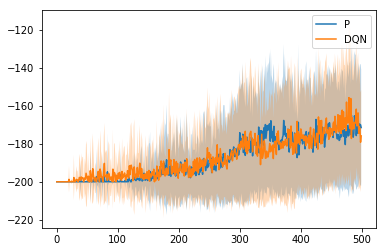

In [26]:

P_scoress_np = np.array(P_scoress)
dqn_scoress_np = np.array(dqn_scoress)
plt.plot(P_episodess[0], mean_P_scores, label="P")
plt.plot(dqn_episodess[0], mean_dqn_scores, label = "DQN")
#plt.plot(P_episodess[0], np.median(np.array(P_scoress), axis=0), label="P")
#plt.plot(dqn_episodess[0], np.median(np.array(dqn_scoress), axis=0), label = "DQN")

plt.fill_between(P_episodess[0], mean_P_scores-P_scoress_np.std(axis=0), mean_P_scores+P_scoress_np.std(axis=0), alpha=0.3)
plt.fill_between(dqn_episodess[0], mean_dqn_scores-dqn_scoress_np.std(axis=0), mean_dqn_scores+dqn_scoress_np.std(axis=0), alpha=0.3)
plt.legend()
plt.show()

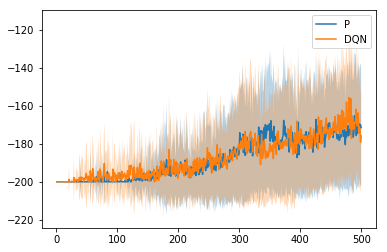

In [17]:
#np.save('mountain_car_trained_P', P_scoress)
#np.save('mountain_car_trained_dqn', dqn_scoress)
P_scoress_load = np.load('mountain_car_trained_P.npy')
dqn_scoress_load = np.load('mountain_car_trained_dqn.npy')

P_scoress_np = np.array(P_scoress_load)
dqn_scoress_np = np.array(dqn_scoress_load)

mean_P_scores = np.zeros(len(P_scoress_load[0]))
for P_scores in P_scoress_np:
    mean_P_scores += np.array(P_scores)
mean_P_scores /= len(P_scoress_np)

mean_dqn_scores = np.zeros(len(dqn_scoress_load[0]))
for dqn_scores in dqn_scoress_np:
    mean_dqn_scores += np.array(dqn_scores)
mean_dqn_scores /= len(dqn_scoress_np)

plt.plot(range(1,501), mean_P_scores, label="P")
plt.plot(range(1,501), mean_dqn_scores, label = "DQN")
#plt.plot(P_episodess[0], np.median(np.array(P_scoress), axis=0), label="P")
#plt.plot(dqn_episodess[0], np.median(np.array(dqn_scoress), axis=0), label = "DQN")

plt.fill_between(range(1,501), mean_P_scores-P_scoress_np.std(axis=0), mean_P_scores+P_scoress_np.std(axis=0), alpha=0.3)
plt.fill_between(range(1,501), mean_dqn_scores-dqn_scoress_np.std(axis=0), mean_dqn_scores+dqn_scoress_np.std(axis=0), alpha=0.3)
plt.legend()
plt.show()

In [20]:
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

(6,)
(21,)
(401,)


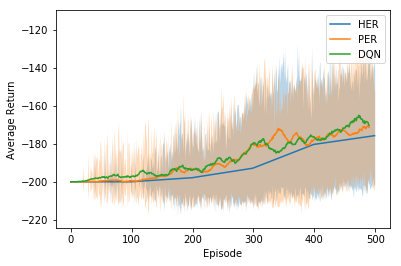

In [29]:
HER_statistics_filename = "HER_statistics"

loaded_statistics = pickle.load(open(HER_statistics_filename, 'rb'))
loaded_test_successes,loaded_test_rewards,loaded_test_stds,loaded_num_updates = loaded_statistics
loaded_test_rewards = np.concatenate([[-200],loaded_test_rewards])

t=np.concatenate([[0],-1+np.arange(100,600,100)])
print(t.shape)
print(loaded_test_rewards.shape)
plt.plot(t,loaded_test_rewards[0:6], label = "HER")
print(smooth(mean_P_scores, 100).shape)
plt.plot(smooth(mean_P_scores, 10), label="PER")
plt.plot(smooth(mean_dqn_scores, 10), label = "DQN")
#plt.plot(P_episodess[0], np.median(np.array(P_scoress), axis=0), label="P")
#plt.plot(dqn_episodess[0], np.median(np.array(dqn_scoress), axis=0), label = "DQN")

plt.fill_between(range(1,501), mean_P_scores-P_scoress_np.std(axis=0), mean_P_scores+P_scoress_np.std(axis=0), alpha=0.3)
plt.fill_between(range(1,501), mean_dqn_scores-dqn_scoress_np.std(axis=0), mean_dqn_scores+dqn_scoress_np.std(axis=0), alpha=0.3)
plt.legend()

plt.xlabel('Episode')
plt.ylabel('Average Return')
plt.show()
